### **LOAD LIBRARIES**

In [1]:
import pandas as pd
import numpy as np

from IPython.display import display
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import chain

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.feature_selection import mutual_info_regression, f_regression

from matplotlib_venn import venn2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from scipy.stats import pearsonr, spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

from sklearn.svm import SVR
import shap
from collections import Counter

from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro, skew, kurtosis

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

### **FUNCTION FOR EDA**

In [2]:
def classify_feature(series):
    # Check for datetime
    if pd.api.types.is_datetime64_any_dtype(series):
        return 'Datetime'

    # Get number of unique non-null values
    n_unique = series.nunique(dropna=True)

    # Raw dtype
    dtype = series.dtype

    # Case 1: If it's already numeric dtype
    if pd.api.types.is_numeric_dtype(series):
        if n_unique == 2:
            return 'Binary (Numeric)'
        elif n_unique < 15:
            return 'Multiclass (Numeric)'
        else:
            return 'Numerical'

    # Case 2: If it's an object or string dtype, check if it can be converted
    elif dtype == 'object' or dtype.name == 'string':
        # Try converting to numeric
        coerced = pd.to_numeric(series, errors='coerce')
        non_na = coerced.notna().sum()
        ratio_numeric = non_na / len(series)

        # If most values (e.g. 90%+) are numeric-looking, treat as numeric
        if ratio_numeric > 0.9:
            if coerced.nunique(dropna=True) == 2:
                return 'Binary (Numeric)'
            elif coerced.nunique(dropna=True) < 15:
                return 'Multiclass (Numeric)'
            else:
                return 'Numerical'

        # Otherwise, treat as categorical
        if n_unique == 2:
            return 'Binary (Categorical)'
        elif n_unique < 15:
            return 'Categorical'
        else:
            return 'High Cardinality Categorical'

    # Default fallback
    else:
        return 'Unknown'


def summarize_feature(series):
    """Generate a summary of key values in the feature."""
    if pd.api.types.is_numeric_dtype(series):
        return f"Mean: {series.mean():.2f}, Median: {series.median():.2f}, Std: {series.std():.2f}"
    elif pd.api.types.is_datetime64_any_dtype(series):
        return f"Min: {series.min()}, Max: {series.max()}"
    else:
        top_categories = series.value_counts(dropna=True).head(3)
        return ', '.join(f"{repr(cat)} ({cnt})" for cat, cnt in top_categories.items())

def generate_enhanced_data_report(df):
    # --------- Dataset Summary ---------
    summary = {
        'Total Rows': df.shape[0],
        'Total Features': df.shape[1],
        'Features with Missing Values': df.isnull().any().sum(),
        'Rows with Missing Values': df.isnull().any(axis=1).sum(),
        'Total Missing Values': df.isnull().sum().sum(),
        'Duplicate Rows': df.duplicated().sum()
    }
    summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Value'])

    # --------- Feature Report ---------
    report_rows = []

    for col in df.columns:
        series = df[col]
        feature_type = classify_feature(series)
        total = len(series)
        missing = series.isnull().sum()
        percent_missing = 100 * missing / total
        n_unique = series.nunique(dropna=True)
        example_values = series.dropna().unique()[:3]

        report_rows.append({
            'Feature': col,
            'Feature Type': feature_type,
            'Data Type':series.dtypes,
            '# Missing': missing,
            '% Missing': f"{percent_missing:.1f}%",
            '# Unique': n_unique,
            'Example Values': ', '.join(map(str, example_values)),
            'Summary Stats': summarize_feature(series)
        })

    feature_report_df = pd.DataFrame(report_rows)

    return summary_df, feature_report_df

### **FUNCTION TO LOAD AND CLEAN DATA**

In [3]:
def load_and_clean_excel(file_path_or_url):
    # Step 1: Load Excel file
    df = pd.read_excel(file_path_or_url, sheet_name="Data")
    print('Loading excel...',df.shape)

    # Step 2: Fix headers if misaligned
    new_columns = []
    for i, col in enumerate(df.columns):
        if ('Unnamed' in col
            or col in [
                'Personality factors',
                'Emotional Likert explicit scores',
                'Workplace / functional Likert explicit scores',
                'Emotional Fast Choice implicit scores',
                'Workplace / functional Fast choice implicit scores'
            ]):
            new_columns.append(df.iloc[0, i])
        else:
            new_columns.append(col)

    df.columns = new_columns
    df = df.drop(index=0).reset_index(drop=True)
    print('Fixed Headers...')

    # Step 3: Generate feature report
    summary, feature_report = generate_enhanced_data_report(df)
    print('Summary of Data',summary)
    display(feature_report)

    # Step 4: Assign proper data types
    for _, row in feature_report.iterrows():
        col = row['Feature']
        ftype = row['Feature Type']

        if ftype in ['Categorical', 'Binary (Categorical)', 'High Cardinality Categorical']:
            df[col] = df[col].astype(str)

        elif ftype == 'Multiclass (Numeric)':
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

        elif ftype == 'Numerical':
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
    print('Fixed Data Types...')

    # Step 5: Final clean-up
    df_clean = df.dropna().reset_index(drop=True)

    print("✅ Cleaned data shape:", df_clean.shape)
    return df_clean


### **FUNCTION TO ENCODE DATA**

In [4]:
def encode_and_scale(df_clean):
    # 1. Define columns
    categorical_cols = [ 'Gender','Batch Group']
    ordinal_col = 'Age'
    age_order = ['18-24', '25-40', '41-64']  # Make sure this is correct

    # 2. Ensure all are strings before encoding
    df_clean[categorical_cols + [ordinal_col]] = df_clean[categorical_cols + [ordinal_col]].astype('string')

    # 3. Label Encode categorical columns
    le = LabelEncoder()
    for col in categorical_cols:
        df_clean[col + '_encoded'] = le.fit_transform(df_clean[col])

        # Print mapping
        mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(f"\n📋 Encoding for column '{col}':")
        for k, v in mapping.items():
          print(f"  {k} → {v}")

    # 4. Ordinal Encode 'Age'
    ordinal_encoder = OrdinalEncoder(categories=[age_order])
    df_clean['Age_encoded'] = ordinal_encoder.fit_transform(df_clean[[ordinal_col]]).astype(int)

    # 5. Get updated feature types
    summary, feature_report = generate_enhanced_data_report(df_clean)
    feature_dict = dict(zip(feature_report['Feature'], feature_report['Feature Type']))

    # 6. Standard scale all numerical features

    df_clean['Prep_org'] = df_clean['Preparedness levels']


    scaler = StandardScaler()
    for feature_name, feature_type in feature_dict.items():
        if feature_type == 'Numerical'and feature_name != 'Prep_org':
            df_clean[feature_name] = scaler.fit_transform(df_clean[[feature_name]])



    # 7. Drop original categorical columns (keep only encoded versions)
    df_scaled = df_clean.drop(columns=categorical_cols + [ordinal_col]).copy()



    print("✅ Scaled DataFrame shape:", df_scaled.shape)
    return df_scaled, mapping,scaler

### **FUNCTION FOR OLS ANALYSIS**

In [5]:
# Lets start with OLS

def concise_regression_summary(train_df, test_df, feature_blocks, target_col='Preparedness levels'):
    print("\n REGRESSION INSIGHT SUMMARY")

    y_train = train_df[target_col]
    y_test = test_df[target_col]

    results = {}

    # Step 1: All features
    all_features = list(chain.from_iterable(
        [y for x, y in feature_blocks.items() if x not in ['target', 'qualitative']]
    ))
    X_train_all = sm.add_constant(train_df[all_features])
    X_test_all = sm.add_constant(test_df[all_features])
    model_all = sm.OLS(y_train, X_train_all).fit()
    y_pred_all = model_all.predict(X_test_all)
    r2_all = r2_score(y_test, y_pred_all)

    print("\n🔹 OLS with All Features:")
    print(f"  - Train R²: {model_all.rsquared:.3f}, Test R²: {r2_all:.3f}, Adj R²: {model_all.rsquared_adj:.3f}")

    # Step 2: Feature block-wise OLS
    block_r2s = {}
    print("\n🔹 OLS by Feature Block:")
    for block, features in feature_blocks.items():
        if block in ['target', 'qualitative']:
            continue
        X_train = sm.add_constant(train_df[features])
        X_test = sm.add_constant(test_df[features])
        model_block = sm.OLS(y_train, X_train).fit()
        y_pred_block = model_block.predict(X_test)
        test_r2 = r2_score(y_test, y_pred_block)
        block_r2s[block] = test_r2
        print(f"  - Block '{block}': Train R² = {model_block.rsquared:.3f}, Test R² = {test_r2:.3f}")
        results[f'block_{block}'] = model_block

    # Step 3: LASSO + OLS on selected features
    selected_feature_blocks = []
    selected_r2s = {}
    print("\n🔹 LASSO + OLS on Selected Features per Block:")
    for block, features in feature_blocks.items():
        if block in ['target', 'qualitative']:
            continue
        X_train_block = train_df[features]
        X_test_block = test_df[features]
        lasso = LassoCV(cv=5, random_state=42).fit(X_train_block, y_train)
        selected_mask = lasso.coef_ != 0
        if any(selected_mask):
            selected_features = X_train_block.columns[selected_mask]
            selected_X_train = sm.add_constant(X_train_block[selected_features])
            selected_X_test = sm.add_constant(X_test_block[selected_features])
            model_sel = sm.OLS(y_train, selected_X_train).fit()
            y_pred_sel = model_sel.predict(selected_X_test)
            test_r2 = r2_score(y_test, y_pred_sel)
            selected_feature_blocks.append(train_df[selected_features])
            selected_r2s[block] = test_r2
            print(f"  - Block '{block}': {len(selected_features)} selected → Test R² = {test_r2:.3f}")
            print(f"Top  : {selected_features}")
        else:
            print(f"  - Block '{block}': ❌ No features selected")

    # Step 4: Combined selected features
    if selected_feature_blocks:
        df_train_selected_combined = pd.concat(selected_feature_blocks, axis=1)
        df_test_selected_combined = pd.concat([test_df[f.columns] for f in selected_feature_blocks], axis=1)
        X_train_combined = sm.add_constant(df_train_selected_combined)
        X_test_combined = sm.add_constant(df_test_selected_combined)
        model_combined = sm.OLS(y_train, X_train_combined).fit()
        y_pred_combined = model_combined.predict(X_test_combined)
        combined_r2 = r2_score(y_test, y_pred_combined)
        print("\n🔹 Combined Selected Features:")
        print(f"  - Train R²: {model_combined.rsquared:.3f}, Test R²: {combined_r2:.3f}")
        results['combined_selected'] = model_combined
    else:
        print("\n⚠️ No features were selected by LASSO from any block.")

    # Step 5: Comparative insights
    print("\n COMPARATIVE INSIGHTS")
    print(f"• All features gave Test R² = {r2_all:.3f}.")
    for block in block_r2s:
        plain = block_r2s[block]
        sel = selected_r2s.get(block, 0)
        if sel > plain:
            print(f"• Block '{block}': Selection improved Test R² from {plain:.3f} → {sel:.3f}. 🎯")
        else:
            print(f"• Block '{block}': Selection did not improve Test R² ({plain:.3f} vs {sel:.3f}).")

    return results


### **FUNCTION FOR REGRESSION ANALYSIS ON IMPLICIT AND EXPLICIT FEATURES**

In [6]:
def comprehensive_regression_analysis(train_df, test_df, feature_blocks, target_col='Preparedness levels'):

    print("\n COMPREHENSIVE REGRESSION ANALYSIS SUITE (NO DATA LEAKAGE)")
    print("="*70)

    # Separate train and test targets
    y_train = train_df[target_col]
    y_test = test_df[target_col]

    results = {}
    test_results = {}
    diagnostics = {}

    # ===============================================
    # PHASE 1: CORE MODEL BUILDING & COMPARISON
    # ===============================================

    print("\n📊 PHASE 1: MODEL BUILDING & PERFORMANCE")
    print("-" * 50)

    # Define feature groups
    explicit_features = feature_blocks['explicit_emotional'] + feature_blocks['explicit_workplace']
    implicit_features = feature_blocks['implicit_emotional'] + feature_blocks['implicit_workplace']
    all_features = explicit_features + implicit_features

    # Build core models ON TRAINING DATA ONLY
    models_to_build = {
        'explicit_only': explicit_features,
        'implicit_only': implicit_features,
        'combined': all_features
    }

    cv_scores = {}
    test_scores = {}

    for model_name, features in models_to_build.items():
        # Train OLS Model on training data
        X_train = sm.add_constant(train_df[features])
        model = sm.OLS(y_train, X_train).fit()
        results[model_name] = model

        # Cross-validation on TRAINING data only (proper approach)
        lr = LinearRegression()
        cv_score = cross_val_score(lr, train_df[features], y_train, cv=5, scoring='r2')
        cv_scores[model_name] = cv_score

        # Test performance on held-out test set
        X_test = sm.add_constant(test_df[features])
        test_pred = model.predict(X_test)
        test_r2 = r2_score(y_test, test_pred)
        test_scores[model_name] = test_r2

        print(f"{model_name.replace('_', ' ').title():<15}: "
              f"Train R²={model.rsquared:.3f}, "
              f"CV R²={cv_score.mean():.3f}±{cv_score.std():.3f}, "
              f"Test R²={test_r2:.3f}")

    # Model comparison metrics (training data)
    print(f"\n📈 Model Information Criteria (Training):")
    for name, model in results.items():
        print(f"{name.replace('_', ' ').title():<15}: AIC={model.aic:.1f}, BIC={model.bic:.1f}")

    # ===============================================
    # PHASE 2: FEATURE SELECTION & OPTIMIZATION
    # ===============================================

    print(f"\n🎯 PHASE 2: LASSO FEATURE SELECTION (Training Data)")
    print("-" * 50)

    selected_features = {}
    lasso_models = {}

    for group_name, features in [('explicit', explicit_features), ('implicit', implicit_features)]:
        # LASSO selection on TRAINING data only
        lasso = LassoCV(cv=5, random_state=42, max_iter=2000)
        lasso.fit(train_df[features], y_train)

        # Get selected features
        selected_mask = lasso.coef_ != 0
        selected = [f for f, sel in zip(features, selected_mask) if sel]
        selected_features[group_name] = selected

        if selected:
            # Build OLS model with selected features on TRAINING data
            X_train_selected = sm.add_constant(train_df[selected])
            model_selected = sm.OLS(y_train, X_train_selected).fit()
            lasso_models[f'{group_name}_lasso'] = model_selected
            results[f'{group_name}_lasso'] = model_selected

            # Test LASSO-selected model on test set
            X_test_selected = sm.add_constant(test_df[selected])
            test_pred_lasso = model_selected.predict(X_test_selected)
            test_r2_lasso = r2_score(y_test, test_pred_lasso)
            test_scores[f'{group_name}_lasso'] = test_r2_lasso

            print(f"{group_name.capitalize():<10}: {len(selected)}/{len(features)} features selected, "
                  f"Train R²={model_selected.rsquared:.3f}, Test R²={test_r2_lasso:.3f}")
        else:
            print(f"{group_name.capitalize():<10}: No features selected by LASSO")

    # ===============================================
    # PHASE 3: INCREMENTAL VALUE & SIGNIFICANCE
    # ===============================================

    print(f"\n💡 PHASE 3: INCREMENTAL VALUE ANALYSIS")
    print("-" * 50)

    # Calculate incremental contributions (training performance)
    r2_explicit_train = results['explicit_only'].rsquared
    r2_implicit_train = results['implicit_only'].rsquared
    r2_combined_train = results['combined'].rsquared

    # Calculate incremental contributions (test performance)
    r2_explicit_test = test_scores['explicit_only']
    r2_implicit_test = test_scores['implicit_only']
    r2_combined_test = test_scores['combined']

    incremental_implicit_train = r2_combined_train - r2_explicit_train
    incremental_explicit_train = r2_combined_train - r2_implicit_train

    incremental_implicit_test = r2_combined_test - r2_explicit_test
    incremental_explicit_test = r2_combined_test - r2_implicit_test

    print("Training Performance:")
    print(f"  Implicit adds over explicit: +{incremental_implicit_train:.3f} R² "
          f"({incremental_implicit_train/r2_explicit_train*100:.1f}% improvement)")
    print(f"  Explicit adds over implicit: +{incremental_explicit_train:.3f} R² "
          f"({incremental_explicit_train/r2_implicit_train*100:.1f}% improvement)")

    print("Test Performance (Unbiased):")
    print(f"  Implicit adds over explicit: +{incremental_implicit_test:.3f} R² "
          f"({incremental_implicit_test/max(r2_explicit_test, 0.001)*100:.1f}% improvement)")
    print(f"  Explicit adds over implicit: +{incremental_explicit_test:.3f} R² "
          f"({incremental_explicit_test/max(r2_implicit_test, 0.001)*100:.1f}% improvement)")

    # Statistical significance test (on training data - this is appropriate)
    n = len(train_df)
    k_implicit = len(implicit_features)
    k_combined = len(all_features)

    rss_explicit = np.sum(results['explicit_only'].resid ** 2)
    rss_combined = np.sum(results['combined'].resid ** 2)

    f_statistic = ((rss_explicit - rss_combined) / k_implicit) / (rss_combined / (n - k_combined - 1))
    p_value = 1 - stats.f.cdf(f_statistic, k_implicit, n - k_combined - 1)

    print(f"\nF-test for implicit features: F={f_statistic:.3f}, p={p_value:.4f}")

    significance_level = "highly significant (***)" if p_value < 0.001 else \
                        "significant (**)" if p_value < 0.01 else \
                        "marginally significant (*)" if p_value < 0.05 else \
                        "not significant"
    print(f"Statistical significance: {significance_level}")

    # ===============================================
    # PHASE 4: CONSTRUCT VALIDITY & CORRELATIONS
    # ===============================================

    print(f"\n🔗 PHASE 4: CONSTRUCT VALIDITY ANALYSIS (Training Data)")
    print("-" * 50)

    # Cross-domain correlations (calculated on training data to avoid leakage)
    cross_correlations = []
    domain_correlations = {'emotional': [], 'workplace': []}

    # Emotional domain
    for exp_feat in feature_blocks['explicit_emotional']:
        for imp_feat in feature_blocks['implicit_emotional']:
            if exp_feat in train_df.columns and imp_feat in train_df.columns:
                corr = train_df[exp_feat].corr(train_df[imp_feat])
                if not np.isnan(corr):
                    cross_correlations.append(abs(corr))
                    domain_correlations['emotional'].append(abs(corr))

    # Workplace domain
    for exp_feat in feature_blocks['explicit_workplace']:
        for imp_feat in feature_blocks['implicit_workplace']:
            if exp_feat in train_df.columns and imp_feat in train_df.columns:
                corr = train_df[exp_feat].corr(train_df[imp_feat])
                if not np.isnan(corr):
                    cross_correlations.append(abs(corr))
                    domain_correlations['workplace'].append(abs(corr))

    avg_cross_corr = np.mean(cross_correlations) if cross_correlations else 0
    avg_emotional_corr = np.mean(domain_correlations['emotional']) if domain_correlations['emotional'] else 0
    avg_workplace_corr = np.mean(domain_correlations['workplace']) if domain_correlations['workplace'] else 0

    print(f"Average cross-correlation (explicit-implicit): {avg_cross_corr:.3f}")
    print(f"  - Emotional domain: {avg_emotional_corr:.3f}")
    print(f"  - Workplace domain: {avg_workplace_corr:.3f}")

    # Construct validity interpretation
    if avg_cross_corr < 0.3:
        validity_msg = "✅ Low correlation - measures capture different constructs (good discriminant validity)"
    elif avg_cross_corr > 0.7:
        validity_msg = "⚠️ High correlation - potential measurement redundancy"
    else:
        validity_msg = "📊 Moderate correlation - partial construct overlap"

    print(f"Construct validity: {validity_msg}")

    # ===============================================
    # PHASE 5: TOP PREDICTIVE FEATURES
    # ===============================================

    print(f"\n🔝 PHASE 5: KEY PREDICTIVE FEATURES (From Training)")
    print("-" * 50)

    # Get top features from LASSO models (trained on training data)
    for group in ['explicit', 'implicit']:
        if f'{group}_lasso' in results:
            coefs = results[f'{group}_lasso'].params.drop('const')
            top_features = coefs.abs().sort_values(ascending=False).head(10)

            print(f"\nTop 3 {group.capitalize()} Features:")
            for i, (feature, coef) in enumerate(top_features.items()):
                direction = "↑" if coef > 0 else "↓"
                print(f"  {i+1}. {feature}: {coef:.3f} {direction}")

    # ===============================================
    # PHASE 6: BUSINESS INSIGHTS & RECOMMENDATIONS
    # ===============================================

    print(f"\n💼 PHASE 6: BUSINESS INSIGHTS & RECOMMENDATIONS")
    print("-" * 50)

    # Base recommendations on TEST performance (unbiased)
    print("📊 UNBIASED TEST SET RESULTS:")
    print(f"  Explicit-only Test R²: {r2_explicit_test:.3f}")
    print(f"  Implicit-only Test R²: {r2_implicit_test:.3f}")
    print(f"  Combined Test R²:      {r2_combined_test:.3f}")

    # Determine superior approach based on test performance
    if r2_implicit_test > r2_explicit_test:
        better_approach = "implicit"
        performance_gap = r2_implicit_test - r2_explicit_test
        print(f"\n🎯 Implicit measures outperform explicit by {performance_gap:.3f} R² points (test set)")
        print("   → Unconscious reactions better predict preparedness than self-reports")
    else:
        better_approach = "explicit"
        performance_gap = r2_explicit_test - r2_implicit_test
        print(f"\n🎯 Explicit measures outperform implicit by {performance_gap:.3f} R² points (test set)")
        print("   → Conscious self-assessment captures key preparedness factors")

    # Combined approach value (test performance)
    combined_improvement_test = r2_combined_test - max(r2_explicit_test, r2_implicit_test)

    if combined_improvement_test > 0.05:
        recommendation = "✅ RECOMMEND: Use both measurement types (substantial added value)"
    elif combined_improvement_test > 0.02:
        recommendation = "📊 CONSIDER: Dual approach (moderate added value vs. cost)"
    else:
        recommendation = f"⚠️ SUFFICIENT: Single approach ({better_approach}) may be adequate"

    print(f"\nCombined approach adds: +{combined_improvement_test:.3f} R² (test set)")
    print(f"Recommendation: {recommendation}")

    # Generalization assessment
    train_test_gap_combined = r2_combined_train - r2_combined_test
    print(f"\n🔍 GENERALIZATION ASSESSMENT:")
    print(f"Train-Test R² gap (combined): {train_test_gap_combined:.3f}")

    if train_test_gap_combined > 0.1:
        generalization_msg = "⚠️ Poor generalization - possible overfitting"
    elif train_test_gap_combined > 0.05:
        generalization_msg = "📊 Moderate generalization gap - monitor performance"
    else:
        generalization_msg = "✅ Good generalization - stable model performance"

    print(f"Generalization: {generalization_msg}")

    # ===============================================
    # COMPILE COMPREHENSIVE RESULTS
    # ===============================================

    comprehensive_metrics = {
        'model_performance': {
            'train_performance': {
                'r2_explicit': r2_explicit_train,
                'r2_implicit': r2_implicit_train,
                'r2_combined': r2_combined_train
            },
            'test_performance': {
                'r2_explicit': r2_explicit_test,
                'r2_implicit': r2_implicit_test,
                'r2_combined': r2_combined_test
            },
            'cv_scores': cv_scores,
            'generalization_gap': train_test_gap_combined
        },
        'incremental_analysis': {
            'train': {
                'incremental_implicit': incremental_implicit_train,
                'incremental_explicit': incremental_explicit_train
            },
            'test': {
                'incremental_implicit': incremental_implicit_test,
                'incremental_explicit': incremental_explicit_test
            },
            'f_statistic': f_statistic,
            'p_value': p_value
        },
        'construct_validity': {
            'avg_cross_correlation': avg_cross_corr,
            'domain_correlations': {
                'emotional': avg_emotional_corr,
                'workplace': avg_workplace_corr
            }
        },
        'feature_selection': {
            'selected_features': selected_features,
            'selection_counts': {k: len(v) for k, v in selected_features.items()}
        },
        'business_insights': {
            'better_approach': better_approach,
            'test_combined_improvement': combined_improvement_test,
            'recommendation': recommendation,
            'generalization_assessment': generalization_msg
        }
    }

    return models_to_build, results, comprehensive_metrics, test_scores

In [7]:


def run_regression_diagnostics(model, X, y, model_name="Model"):
    print(f"\n🧪 REGRESSION DIAGNOSTICS FOR: {model_name}")
    print("=" * 60)

    residuals = model.resid
    fitted_vals = model.fittedvalues

    # RESIDUAL SUMMARY
    mean_resid = np.mean(residuals)
    std_resid = np.std(residuals)
    skew_resid = skew(residuals)
    kurt_resid = kurtosis(residuals, fisher=False)
    shapiro_stat, shapiro_p = shapiro(residuals)
    dw_stat = durbin_watson(residuals)

    print(f"\nRESIDUAL ANALYSIS")
    print("-" * 40)
    print(f"Residual Analysis for {model_name}:")
    print(f"  - Mean residual: {mean_resid:.6f}")
    print(f"  - Std residual: {std_resid:.3f}")
    print(f"  - Skewness: {skew_resid:.3f}")
    print(f"  - Kurtosis: {kurt_resid:.3f}")
    print(f"  - Normality (Shapiro-Wilk): {'✅ Normal' if shapiro_p >= 0.05 else '⚠️ Non-normal'} (p={shapiro_p:.4f})")
    print(f"  - Autocorrelation (Durbin-Watson): {'✅ No autocorrelation' if 1.5 < dw_stat < 2.5 else '⚠️ Possible autocorrelation'} (DW={dw_stat:.3f})")

    # 1. LINEARITY: Residuals vs. Fitted
    plt.figure(figsize=(6, 4))
    sns.residplot(x=fitted_vals, y=residuals, lowess=True, line_kws={'color': 'red'})
    plt.axhline(0, linestyle='--', color='grey')
    plt.title(f"{model_name} - Residuals vs Fitted (Linearity)")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    # 2. HOMOSCEDASTICITY: Breusch-Pagan test
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_breuschpagan(residuals, model.model.exog)
    print(f"\nHOMOSCEDASTICITY (Breusch-Pagan):")
    print(f"  - LM stat = {lm_stat:.3f}, p = {lm_pvalue:.4f}")
    print(f"  - F stat  = {f_stat:.3f}, p = {f_pvalue:.4f}")
    if f_pvalue < 0.05:
        print("  ⚠️ Heteroscedasticity detected (variance not constant)")
    else:
        print("  ✅ Homoscedasticity assumption holds")

    # 3. NORMALITY: Q-Q plot
    sm.qqplot(residuals, line='s')
    plt.title(f"{model_name} - Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()

    # 4. MULTICOLLINEARITY: Top 10 VIF
    print(f"\nMULTICOLLINEARITY (Top 10 VIF):")
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    top_vif = vif_data.sort_values("VIF", ascending=False).head(10)
    print(top_vif.round(2))

    # 5. INFLUENTIAL POINTS: Cook's Distance
    infl = model.get_influence()
    cooks_d = infl.cooks_distance[0]
    threshold = 4 / len(X)

    plt.figure(figsize=(6, 4))
    plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
    plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
    plt.title(f"{model_name} - Cook's Distance (Influential Points)")
    plt.xlabel("Observation Index")
    plt.ylabel("Cook's Distance")
    plt.legend()
    plt.tight_layout()
    plt.show()

    num_influential = sum(cooks_d > threshold)
    print(f"\nINFLUENTIAL POINTS (Cook's Distance):")
    print(f"  - {num_influential} observations exceed threshold (4/n = {threshold:.4f})")


### **MORE PREDICTIVE ANALYSIS ON PREPAREDENESS LEVELS**

In [8]:
#  Clearly features have non linear relations .. lets analyse features a bit more

def feature_informativeness(X, y, top_n=10, plot=True):
    """Compute and rank features, with optional plotting"""

    mi = mutual_info_regression(X, y)
    f_vals, _ = f_regression(X, y)
    pearson_corr = [pearsonr(X[col], y)[0] for col in X.columns]
    spearman_corr = [spearmanr(X[col], y)[0] for col in X.columns]

    info_df = pd.DataFrame({
        'Feature': X.columns,
        'Mutual_Info': mi,
        'F_stat': f_vals,
        'Pearson_corr': pearson_corr,
        'Spearman_corr': spearman_corr
    }).sort_values('Mutual_Info', ascending=False).reset_index(drop=True)

    if plot:
        top_features = info_df.head(top_n)
        plt.figure(figsize=(8, 5))
        sns.barplot(x='Mutual_Info', y='Feature', data=top_features, palette='viridis')
        plt.title(f"Top {top_n} Features by Mutual Information")
        plt.xlabel("Mutual Information Score")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()

    return info_df

In [9]:
def incremental_feature_selection(X, y, ranking_df, model=RidgeCV(), scoring='r2', max_features=30):
    results = []
    top_features = ranking_df['Feature'].tolist()

    for k in range(1, min(max_features, len(top_features)) + 1):
        selected = top_features[:k]
        X_sub = X[selected]

        # Cross-validated performance
        scores = cross_val_score(model, X_sub, y, cv=5, scoring=scoring)
        model.fit(X_sub,y)
        y_pred = model.predict(test_df[selected])
        r_sq = r2_score(test_df['Preparedness levels'],y_pred)
        results.append((k, scores.mean(), scores.std(),r_sq))

    results_df = pd.DataFrame(results, columns=['Num_Features', 'Mean_Score', 'Std_Score','Test_R2'])

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(results_df['Num_Features'], results_df['Mean_Score'], marker='o')
    plt.fill_between(results_df['Num_Features'],
                     results_df['Mean_Score'] - results_df['Std_Score'],
                     results_df['Mean_Score'] + results_df['Std_Score'],
                     alpha=0.2)
    plt.title(f'Model Performance vs. Number of Features ({scoring})')
    plt.xlabel("Number of Features")
    plt.ylabel(f"Cross-validated {scoring}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Best number of features
    best_row = results_df.loc[results_df['Mean_Score'].idxmax()]
    k_best = int(best_row.Num_Features)
    best_features = top_features[:k_best]

    print(f"\n🏆 Best performance with {k_best} features: {best_row.Mean_Score:.3f} ± {best_row.Std_Score:.3f}")
    print(f"🧠 Top {k_best} most informative features used:")
    for i, feat in enumerate(best_features, start=1):
        print(f"{i:2d}. {feat}")

    return results_df, best_features

In [10]:
def train_and_evaluate_models(train_df, test_df, target_col, feature_list):
    models = {
        'Ridge': RidgeCV(),
        'Lasso': LassoCV(cv=5),
        'SVR': SVR(kernel='rbf'),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }

    X_train = train_df[feature_list]
    y_train = train_df[target_col]
    X_test = test_df[feature_list]
    y_test = test_df[target_col]

    results = []
    model_objects = {}
    y_preds = {}

    for name, model in models.items():
        print(f"\n🔍 Training {name}...")
        model.fit(X_train, y_train)

         # Cross-validation on training set
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        cv_mean = np.mean(cv_scores)

        y_pred = model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        bias = np.mean(y_test - y_pred)

        results.append({'Model': name, 'cv_score':cv_mean,'Test_R2': r2, 'RMSE': rmse, 'MAE': mae, 'Bias': bias})
        model_objects[name] = model
        y_preds[name] = y_pred

        # Reliability Plot
        plt.figure(figsize=(5, 5))
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.title(f'{name} - Predicted vs Actual')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Residual Plot
        residuals = y_test - y_pred
        plt.figure(figsize=(5, 4))
        sns.histplot(residuals, kde=True)
        plt.axvline(0, color='r', linestyle='--')
        plt.title(f'{name} - Residual Distribution')
        plt.xlabel('Residual')
        plt.tight_layout()
        plt.show()

    results_df = pd.DataFrame(results).sort_values(by='Test_R2', ascending=False)
    print("\n📊 Model Comparison:")
    display(results_df)

    return results_df, model_objects, y_preds, X_test



In [11]:
def shap_feature_importance(best_model, X_test, feature_names, model_type='tree'):
    print(f"\n🔎 SHAP Analysis for {best_model.__class__.__name__}")

    if model_type == 'tree':
        explainer = shap.TreeExplainer(best_model)
    else:
        explainer = shap.Explainer(best_model, X_test)

    shap_values = explainer(X_test)

    shap.plots.beeswarm(shap_values, max_display=20)
    shap.plots.bar(shap_values, max_display=20)


### **FUNCTION FOR COUNTRY WISE ANALYSIS**

In [12]:
def enhanced_country_level_analysis(train_df, test_df, feature_blocks, selected_features,
                                    target_col='Preparedness levels', country_col='Batch Group_encoded'):
    print("\n🌍 ENHANCED COUNTRY-LEVEL ANALYSIS")
    print("="*60)

    # Check unique countries
    countries = train_df[country_col].unique()
    print(f"📍 Found {len(countries)} countries/regions: {countries}")

    # Determine feature types
    explicit_features = feature_blocks['explicit_emotional'] + feature_blocks['explicit_workplace']
    implicit_features = feature_blocks['implicit_emotional'] + feature_blocks['implicit_workplace']

    print(f"\n🔍 Feature Summary:")
    print(f"  - Selected features: {len(selected_features)}")
    print(f"  - Explicit features: {len([f for f in selected_features if f in explicit_features])}")
    print(f"  - Implicit features: {len([f for f in selected_features if f in implicit_features])}")

    # PHASE 1: Individual Country Modeling
    print(f"\n📊 PHASE 1: INDIVIDUAL COUNTRY MODELING")
    print("-" * 50)

    country_results = {}
    country_performance = {}
    country_sample_sizes = {}
    country_feature_importance = {}


    models = {
        'Ridge': RidgeCV(),
        'Lasso': LassoCV(cv=5),
        'SVR': SVR(kernel='rbf'),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }

    for country in countries:
        train_country = train_df[train_df[country_col] == country].copy()
        test_country = test_df[test_df[country_col] == country].copy()
        train_size = len(train_country)
        test_size = len(test_country)
        total_size = train_size + test_size
        country_sample_sizes[country] = total_size

        print(f"\n🏴 Country {country}: {total_size} samples (Train: {train_size}, Test: {test_size})")

        if train_size >= 30 and test_size >= 20:
            try:
                X_train = train_country[selected_features]
                y_train = train_country[target_col]
                X_test = test_country[selected_features]
                y_test = test_country[target_col]

                country_model_results = {}

                for model_name, model in models.items():
                    model.fit(X_train, y_train)

                    train_pred = model.predict(X_train)
                    test_pred = model.predict(X_test)

                    train_r2 = r2_score(y_train, train_pred)
                    test_r2 = r2_score(y_test, test_pred)
                    generalization_gap = train_r2 - test_r2

                    full_data = pd.concat([X_train, X_test])
                    full_target = pd.concat([y_train, y_test])

                    cv_scores = cross_val_score(model, full_data, full_target, cv=5, scoring='r2')
                    cv_mean = cv_scores.mean()
                    cv_std = cv_scores.std()

                    country_model_results[model_name] = {
                        'train_r2': train_r2,
                        'test_r2': test_r2,
                        'generalization_gap': generalization_gap,
                        'cv_mean': cv_mean,
                        'cv_std': cv_std,
                        'model': model
                    }

                best_model_name = max(country_model_results, key=lambda x: country_model_results[x]['cv_mean'])
                best_model_info = country_model_results[best_model_name]
                best_model = best_model_info['model']

                if hasattr(best_model, 'feature_importances_'):
                    importance_scores = best_model.feature_importances_
                elif hasattr(best_model, 'coef_'):
                    importance_scores = np.abs(best_model.coef_)
                else:
                    importance_scores = np.zeros(len(selected_features))

                feature_importance = pd.DataFrame({
                    'feature': selected_features,
                    'importance': importance_scores
                }).sort_values('importance', ascending=False)

                country_results[country] = {
                    'best_model': best_model_name,
                    'model_results': country_model_results,
                    'feature_importance': feature_importance,
                    'sample_size': total_size
                }

                country_performance[country] = {
                    'best_model': best_model_name,
                    'train_r2': best_model_info['train_r2'],
                    'test_r2': best_model_info['test_r2'],
                    'cv_mean': best_model_info['cv_mean'],
                    'cv_std': best_model_info['cv_std'],
                    'generalization_gap': best_model_info['generalization_gap'],
                    'sample_size': total_size
                }

                country_feature_importance[country] = feature_importance.head(10)

                print(f"   ✅ Best Model: {best_model_name}")
                print(f"   📊 Test R² = {best_model_info['test_r2']:.3f}, CV = {best_model_info['cv_mean']:.3f}±{best_model_info['cv_std']:.3f}")
                print(f"   🎯 Top 3 Features: {', '.join(feature_importance.head(3)['feature'])}")

            except Exception as e:
                print(f"   ❌ Error fitting model: {str(e)}")
        else:
            print(f"   ⚠️  Insufficient train/test size (min 30 train & 20 test)")

    if country_performance:
        print(f"\n📊 COUNTRY MODEL PERFORMANCE COMPARISON:")
        performance_df = pd.DataFrame(country_performance).T
        performance_df = performance_df.sort_values('test_r2', ascending=False)
        print(performance_df[['best_model', 'test_r2', 'cv_mean', 'generalization_gap', 'sample_size']].to_string())

    # PHASE 2: Clustering
    print(f"\n🔗 PHASE 2: COUNTRY CLUSTERING ANALYSIS")
    print("-" * 50)

    if len(country_feature_importance) >= 3:
        clustering_matrix = []
        clustering_countries = []

        for country, importance_df in country_feature_importance.items():
            top_10 = importance_df.head(10)['importance'].values
            top_10 = np.pad(top_10, (0, 10 - len(top_10)))
            clustering_matrix.append(top_10)
            clustering_countries.append(country)

        clustering_matrix = np.array(clustering_matrix)
        n_clusters = min(4, max(2, len(clustering_countries) // 2))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(clustering_matrix)

        clusters = {}
        for i, country in enumerate(clustering_countries):
            cluster_id = cluster_labels[i]
            clusters.setdefault(cluster_id, []).append(country)

        cluster_profiles = {}
        print(f"🎯 COUNTRY CLUSTERS (K={n_clusters}):")
        for cluster_id, countries_in_cluster in clusters.items():
            # print(f"Cluster {cluster_id + 1}: {', '.join(countries_in_cluster)}")
            print(f"Cluster {cluster_id + 1}: {', '.join(str(c) for c in countries_in_cluster)}")

            features, performances = [], []
            for country in countries_in_cluster:
                features += country_feature_importance[country].head(3)['feature'].tolist()
                performances.append(country_performance[country]['test_r2'])

            feature_counts = Counter(features)
            common_features = [feat for feat, _ in feature_counts.most_common(3)]

            cluster_profiles[cluster_id] = {
                'countries': countries_in_cluster,
                'common_features': common_features,
                'avg_performance': np.mean(performances),
                'performance_std': np.std(performances)
            }

        print(f"\n📈 CLUSTER CHARACTERISTICS:")
        for cid, profile in cluster_profiles.items():
            print(f"Cluster {cid + 1}:")
            print(f"  Countries: {', '.join(str(c) for c in profile['countries'])}")
            # print(f"  Countries: {', '.join(profile['countries'])}")
            print(f"  Key Features: {', '.join(profile['common_features'])}")
            print(f"  Avg Performance: {profile['avg_performance']:.3f}")
            if profile['performance_std'] > 0:
                print(f"  Performance Std: {profile['performance_std']:.3f}")

    # PHASE 3: Implicit vs Explicit
    print(f"\n🎭 PHASE 3: IMPLICIT VS EXPLICIT ANALYSIS BY COUNTRY")
    print("-" * 50)

    implicit_explicit_analysis = {}
    implicit_dominant_countries = []
    explicit_dominant_countries = []

    for country, importance_df in country_feature_importance.items():
        total_importance = importance_df['importance'].sum()
        implicit_importance = importance_df[importance_df['feature'].isin(implicit_features)]['importance'].sum()
        explicit_importance = importance_df[importance_df['feature'].isin(explicit_features)]['importance'].sum()

        if total_importance > 0:
            implicit_pct = (implicit_importance / total_importance) * 100
            explicit_pct = (explicit_importance / total_importance) * 100
        else:
            implicit_pct = explicit_pct = 0

        implicit_explicit_analysis[country] = {
            'explicit_pct': explicit_pct,
            'implicit_pct': implicit_pct,
            'explicit_importance': explicit_importance,
            'implicit_importance': implicit_importance,
            'total_importance': total_importance
        }

        if implicit_pct > explicit_pct:
            implicit_dominant_countries.append((country, implicit_pct))
        else:
            explicit_dominant_countries.append((country, explicit_pct))

    print(f"🔮 IMPLICIT-DOMINANT COUNTRIES ({len(implicit_dominant_countries)}):")
    for country, pct in sorted(implicit_dominant_countries, key=lambda x: x[1], reverse=True):
        print(f"  {country}: {pct:.1f}% implicit")

    print(f"\n📋 EXPLICIT-DOMINANT COUNTRIES ({len(explicit_dominant_countries)}):")
    for country, pct in sorted(explicit_dominant_countries, key=lambda x: x[1], reverse=True):
        print(f"  {country}: {pct:.1f}% explicit")

    # PHASE 4: Cross-Country Consistency
    print(f"\n🌐 PHASE 4: CROSS-COUNTRY FEATURE CONSISTENCY")
    print("-" * 50)

    all_features_across_countries = []
    for importance_df in country_feature_importance.values():
        all_features_across_countries += importance_df.head(5)['feature'].tolist()

    feature_frequency = Counter(all_features_across_countries)
    consistent_features = feature_frequency.most_common(10)

    print("🎯 MOST CONSISTENT FEATURES:")
    for feature, count in consistent_features:
        pct = (count / len(country_feature_importance)) * 100
        print(f"  {feature:40} | {count} countries ({pct:.1f}%)")

    # PHASE 5: Recommendations
    print(f"\n💡 PHASE 5: COUNTRY-SPECIFIC RECOMMENDATIONS")
    print("-" * 50)

    recommendations = {}
    for country in countries:
        if country in country_performance:
            recs = []
            perf = country_performance[country]
            imp = implicit_explicit_analysis[country]

            # Performance recommendations
            if perf['test_r2'] >= 0.8:
                recs.append("✅ High predictive accuracy")
            elif perf['test_r2'] >= 0.6:
                recs.append("📊 Moderate accuracy – consider feature engineering")
            else:
                recs.append("⚠️ Low accuracy – model improvements needed")

            if perf['generalization_gap'] < 0.05:
                recs.append("✅ Good generalization")
            else:
                recs.append("⚠️ Overfitting risk – try regularization")

            if imp['explicit_pct'] > 70:
                recs.append("📋 Emphasize explicit indicators")
            elif imp['implicit_pct'] > 70:
                recs.append("🔮 Emphasize implicit indicators")
            else:
                recs.append("⚖️ Balanced implicit-explicit strategy")

            recommendations[country] = recs
            print(f"\n🏴 {country}:")
            for r in recs:
                print(f"  {r}")

    return {
        'country_performance': country_performance,
        'country_results': country_results,
        'country_feature_importance': country_feature_importance,
        'cluster_profiles': cluster_profiles if 'cluster_profiles' in locals() else {},
        'implicit_explicit_analysis': implicit_explicit_analysis,
        'implicit_dominant_countries': implicit_dominant_countries,
        'explicit_dominant_countries': explicit_dominant_countries,
        'consistent_features': consistent_features,
        'country_sample_sizes': country_sample_sizes,
        'recommendations': recommendations
    }


In [13]:
def plot_country_clusters(enhanced_results):

    # Extract data from results
    cluster_profiles = enhanced_results.get('cluster_profiles', {})
    country_feature_importance = enhanced_results.get('country_feature_importance', {})
    country_performance = enhanced_results.get('country_performance', {})

    if not cluster_profiles or not country_feature_importance:
        print("⚠️ No cluster data available for plotting")
        return

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))

    # ==========================================
    # PLOT 1: Country Clusters in 2D PCA Space
    # ==========================================
    ax1 = plt.subplot(2, 3, 1)

    # Prepare clustering data for PCA
    clustering_data = []
    clustering_countries = []
    cluster_labels = []

    for cluster_id, profile in cluster_profiles.items():
        for country in profile['countries']:
            if country in country_feature_importance:
                # Use top 10 feature importances
                importance_values = country_feature_importance[country].head(10)['importance'].values
                if len(importance_values) < 10:
                    importance_values = np.pad(importance_values, (0, 10 - len(importance_values)))

                clustering_data.append(importance_values)
                clustering_countries.append(country)
                cluster_labels.append(cluster_id)

    if len(clustering_data) >= 2:
        # PCA for visualization
        pca = PCA(n_components=2)
        pca_data = pca.fit_transform(clustering_data)

        # Create scatter plot
        colors = plt.cm.Set1(np.linspace(0, 1, len(cluster_profiles)))
        for i, (cluster_id, profile) in enumerate(cluster_profiles.items()):
            cluster_mask = [label == cluster_id for label in cluster_labels]
            cluster_pca = pca_data[cluster_mask]
            cluster_countries_filtered = [country for j, country in enumerate(clustering_countries) if cluster_mask[j]]

            ax1.scatter(cluster_pca[:, 0], cluster_pca[:, 1],
                       c=[colors[i]], label=f'Cluster {cluster_id + 1}',
                       s=100, alpha=0.7, edgecolors='black')

            # Add country labels
            for j, (x, y) in enumerate(cluster_pca):
                ax1.annotate(cluster_countries_filtered[j], (x, y),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax1.set_title('Country Clusters (PCA Space)', fontsize=12, fontweight='bold')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # ==========================================
    # PLOT 2: Cluster Performance Comparison
    # ==========================================
    ax2 = plt.subplot(2, 3, 2)

    cluster_perf_data = []
    cluster_names = []

    for cluster_id, profile in cluster_profiles.items():
        cluster_names.append(f'Cluster {cluster_id + 1}')
        cluster_perf_data.append(profile['avg_performance'])

    bars = ax2.bar(cluster_names, cluster_perf_data,
                   color=['lightblue', 'lightcoral', 'lightgreen', 'gold'][:len(cluster_names)],
                   alpha=0.7, edgecolor='black')

    # Add value labels on bars
    for bar, value in zip(bars, cluster_perf_data):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    ax2.set_title('Average Model Performance by Cluster', fontsize=12, fontweight='bold')
    ax2.set_ylabel('R² Score')
    ax2.set_ylim(0, max(cluster_perf_data) * 1.2 if cluster_perf_data else 1)
    ax2.grid(True, alpha=0.3, axis='y')

In [14]:
def c_heatmap(enhanced_results, c_mapping=None):

    # Extract data from results
    cluster_profiles = enhanced_results.get('cluster_profiles', {})
    country_feature_importance = enhanced_results.get('country_feature_importance', {})

    if not cluster_profiles or not country_feature_importance:
        print("⚠️ No cluster data available for plotting")
        return

    # Create figure with enhanced layout
    fig = plt.figure(figsize=(20, 12))


    # ==========================================
    # PLOT 3: Cluster Characteristics Heatmap
    # ==========================================
    ax3 = plt.subplot(2, 3, 4)

    # Create feature importance matrix for clusters
    all_features = set()
    for cluster_id, profile in cluster_profiles.items():
        all_features.update(profile.get('common_features', []))

    if all_features:
        all_features = list(all_features)
        feature_matrix = np.zeros((len(cluster_profiles), len(all_features)))

        for i, (cluster_id, profile) in enumerate(cluster_profiles.items()):
            common_features = profile.get('common_features', [])
            for j, feature in enumerate(all_features):
                if feature in common_features:
                    feature_matrix[i, j] = 1

        # Create heatmap
        im = ax3.imshow(feature_matrix, cmap='RdYlBu_r', aspect='auto', alpha=0.8)

        # Set ticks and labels
        ax3.set_xticks(range(len(all_features)))
        ax3.set_xticklabels([feat[:15] + '...' if len(feat) > 15 else feat
                            for feat in all_features], rotation=45, ha='right')
        ax3.set_yticks(range(len(cluster_profiles)))
        ax3.set_yticklabels([f'Cluster {i+1}' for i in cluster_profiles.keys()])

        # Add text annotations
        for i in range(len(cluster_profiles)):
            for j in range(len(all_features)):
                text = '✓' if feature_matrix[i, j] == 1 else ''
                ax3.text(j, i, text, ha="center", va="center",
                        fontsize=12, fontweight='bold', color='white')

    ax3.set_title('Key Features by Cluster', fontsize=12, fontweight='bold')

### **FUNCTION FOR SEGMENTATION**

In [19]:
# Also add a function to create preparedness level bins
def create_preparedness_bins(df_scaled, prep_col='Prep_org'):
    """Create meaningful preparedness level categories"""
    if prep_col not in df_scaled.columns:
        prep_col = 'Preparedness levels'

    def categorize_prep(score):
        if score >= 9.0:
            return "🟢 Excellent (9.0-10.0)"
        elif score >= 8.0:
            return "🟡 High (8.0-8.9)"
        elif score >= 7.0:
            return "🟠 Good (7.0-7.9)"
        elif score >= 6.0:
            return "🔴 Moderate (6.0-6.9)"
        elif score >= 5.0:
            return "🟤 Low (5.0-5.9)"
        else:
            return "⚫ Very Low (<5.0)"

    df_scaled['Prep_Category'] = df_scaled[prep_col].apply(categorize_prep)

    print("\n📊 PREPAREDNESS LEVEL DISTRIBUTION:")
    prep_dist = df_scaled['Prep_Category'].value_counts().sort_index()
    for category, count in prep_dist.items():
        percentage = count / len(df_scaled) * 100
        print(f"   {category}: {count:,} ({percentage:.1f}%)")

    return df_scaled

In [20]:
def advanced_segmentation_analysis(df_scaled, feature_blocks, target_col='Preparedness levels'):
    """
    Perform comprehensive segmentation analysis using multiple methods
    """
    print("\n👥 ADVANCED SEGMENTATION ANALYSIS")
    print("="*50)

    # Select features for clustering (exclude demographics and target)
    clustering_features = []
    for block_name, features in feature_blocks.items():
        if block_name in ['personality_traits', 'explicit_emotional', 'implicit_emotional',
                         'explicit_workplace', 'implicit_workplace']:
            clustering_features.extend(features)

    print(f"🎯 Using {len(clustering_features)} features for clustering")

    X_cluster = df_scaled[clustering_features]

    # -----------------------------------------------------------------------
    # METHOD 1: K-Means with Optimal Cluster Selection
    # -----------------------------------------------------------------------

    print("\n🔍 K-MEANS CLUSTERING ANALYSIS:")

    # Test different numbers of clusters
    k_range = range(2, 8)
    silhouette_scores = []
    inertia_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_cluster)
        silhouette_avg = silhouette_score(X_cluster, cluster_labels)

        silhouette_scores.append(silhouette_avg)
        inertia_scores.append(kmeans.inertia_)

        print(f"  K={k}: Silhouette Score = {silhouette_avg:.3f}, Inertia = {kmeans.inertia_:.0f}")

    # Select optimal K
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"🏆 Optimal K selected: {optimal_k} (highest silhouette score)")

    # Final K-means clustering
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_labels = final_kmeans.fit_predict(X_cluster)

    # -----------------------------------------------------------------------
    # METHOD 2: Gaussian Mixture Model
    # -----------------------------------------------------------------------

    print("\n🔍 GAUSSIAN MIXTURE MODEL ANALYSIS:")

    bic_scores = []
    aic_scores = []

    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(X_cluster)

        bic_scores.append(gmm.bic(X_cluster))
        aic_scores.append(gmm.aic(X_cluster))

        print(f"  K={k}: BIC = {gmm.bic(X_cluster):.0f}, AIC = {gmm.aic(X_cluster):.0f}")

    # Select optimal K (lowest BIC)
    optimal_k_gmm = k_range[np.argmin(bic_scores)]
    print(f"🏆 Optimal K for GMM: {optimal_k_gmm} (lowest BIC)")

    # Final GMM clustering
    final_gmm = GaussianMixture(n_components=optimal_k_gmm, random_state=42)
    gmm_labels = final_gmm.fit_predict(X_cluster)

    # -----------------------------------------------------------------------
    # SEGMENT PROFILING
    # -----------------------------------------------------------------------

    def profile_segments(cluster_labels, method_name):
        print(f"\n📊 {method_name} SEGMENT PROFILES:")

        df_with_clusters = df_scaled.copy()
        df_with_clusters['cluster'] = cluster_labels

        segment_profiles = {}

        for cluster_id in np.unique(cluster_labels):
            cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]

            profile = {
                'size': len(cluster_data),
                'percentage': len(cluster_data) / len(df_with_clusters) * 100,
                'preparedness_mean': cluster_data['Prep_org'].mean(),
                'preparedness_std': cluster_data['Prep_org'].std(),
                'preparedness_median': cluster_data['Prep_org'].median(),
                'preparedness_min': cluster_data['Prep_org'].min(),
                'preparedness_max': cluster_data['Prep_org'].max()
            }

            # Calculate means for each feature block
            for block_name, features in feature_blocks.items():
                if block_name not in ['target', 'qualitative'] and features:
                    available_features = [f for f in features if f in cluster_data.columns]
                    if available_features:
                        profile[f'{block_name}_mean'] = cluster_data[available_features].mean().mean()

            segment_profiles[f'Segment_{cluster_id}'] = profile

            print(f"\n🏷️  Segment {cluster_id}:")
            print(f"   Size: {profile['size']} ({profile['percentage']:.1f}%)")
            print(f"   Preparedness: {profile['preparedness_mean']:.3f} ± {profile['preparedness_std']:.3f}")
            print(f"   Median: {profile['preparedness_median']:.3f} | Min: {profile['preparedness_min']:.3f} | Max: {profile['preparedness_max']:.3f}")

            # Show distinguishing characteristics
            cluster_means = cluster_data[clustering_features].mean()
            overall_means = df_scaled[clustering_features].mean()
            differences = cluster_means - overall_means

            # Top 5 distinguishing features
            top_diffs = differences.abs().nlargest(5)
            print("   Top distinguishing features:")
            for feat in top_diffs.index:
                diff = differences[feat]
                direction = "higher" if diff > 0 else "lower"
                print(f"     {feat[:35]:35} | {direction:6} by {abs(diff):.3f}")

        return segment_profiles

    # Profile both clustering methods
    kmeans_profiles = profile_segments(kmeans_labels, "K-MEANS")
    gmm_profiles = profile_segments(gmm_labels, "GAUSSIAN MIXTURE")

    # -----------------------------------------------------------------------
    # STATISTICAL VALIDATION
    # -----------------------------------------------------------------------

    def validate_segments(cluster_labels, method_name):
        print(f"\n🔬 STATISTICAL VALIDATION - {method_name}:")

        df_with_clusters = df_scaled.copy()
        df_with_clusters['cluster'] = cluster_labels

        # ANOVA test for preparedness differences
        groups = [df_with_clusters[df_with_clusters['cluster'] == i][target_col]
                 for i in np.unique(cluster_labels)]

        f_stat, p_value = stats.f_oneway(*groups)
        print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.4f}")

        if p_value < 0.05:
            print("✅ Segments have significantly different preparedness levels")
        else:
            print("❌ No significant differences between segments")

        return f_stat, p_value

    kmeans_f, kmeans_p = validate_segments(kmeans_labels, "K-MEANS")
    gmm_f, gmm_p = validate_segments(gmm_labels, "GMM")

    return {
        'kmeans': {
            'labels': kmeans_labels,
            'profiles': kmeans_profiles,
            'optimal_k': optimal_k,
            'silhouette_scores': silhouette_scores,
            'f_stat': kmeans_f,
            'p_value': kmeans_p
        },
        'gmm': {
            'labels': gmm_labels,
            'profiles': gmm_profiles,
            'optimal_k': optimal_k_gmm,
            'bic_scores': bic_scores,
            'f_stat': gmm_f,
            'p_value': gmm_p
        },
        'clustering_features': clustering_features
    }

In [21]:
def apply_segmentation_to_test(segmentation_results, train_df, test_df, feature_blocks, target_col='Preparedness levels'):
    """
    Apply fitted clustering models to test data and evaluate generalization
    """
    print("\n🔬 APPLYING FITTED CLUSTERING MODELS TO TEST DATA")
    print("="*60)

    # Get the same clustering features used in training
    clustering_features = segmentation_results['clustering_features']

    # Prepare test data
    X_test = test_df[clustering_features]
    X_train = train_df[clustering_features]

    # -----------------------------------------------------------------------
    # APPLY K-MEANS MODEL TO TEST DATA
    # -----------------------------------------------------------------------
    print("\n🔍 K-MEANS GENERALIZATION:")

    # Re-fit K-means on training data to get the fitted model
    optimal_k = segmentation_results['kmeans']['optimal_k']
    kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_train_labels = kmeans_model.fit_predict(X_train)

    # Apply to test data
    kmeans_test_labels = kmeans_model.predict(X_test)

    # Evaluate test data clustering quality
    test_silhouette = silhouette_score(X_test, kmeans_test_labels)
    train_silhouette = silhouette_score(X_train, kmeans_train_labels)

    print(f"   Training Silhouette Score: {train_silhouette:.3f}")
    print(f"   Test Silhouette Score: {test_silhouette:.3f}")
    print(f"   Generalization Gap: {train_silhouette - test_silhouette:.3f}")

    if abs(train_silhouette - test_silhouette) < 0.05:
        print("   ✅ Good generalization (gap < 0.05)")
    elif abs(train_silhouette - test_silhouette) < 0.1:
        print("   📊 Moderate generalization (gap < 0.1)")
    else:
        print("   ⚠️ Poor generalization (gap >= 0.1)")

    # -----------------------------------------------------------------------
    # APPLY GMM MODEL TO TEST DATA
    # -----------------------------------------------------------------------
    print("\n🔍 GMM GENERALIZATION:")

    # Re-fit GMM on training data
    optimal_k_gmm = segmentation_results['gmm']['optimal_k']
    gmm_model = GaussianMixture(n_components=optimal_k_gmm, random_state=42)
    gmm_train_labels = gmm_model.fit_predict(X_train)

    # Apply to test data
    gmm_test_labels = gmm_model.predict(X_test)

    # Evaluate test data
    test_bic = gmm_model.bic(X_test)
    train_bic = gmm_model.bic(X_train)

    print(f"   Training BIC: {train_bic:.0f}")
    print(f"   Test BIC: {test_bic:.0f}")
    print(f"   BIC Difference: {test_bic - train_bic:.0f}")

    # -----------------------------------------------------------------------
    # CLUSTER STABILITY ANALYSIS
    # -----------------------------------------------------------------------
    print("\n📊 CLUSTER STABILITY ANALYSIS:")

    # Analyze preparedness distribution stability between train/test
    prep_orig_col = 'Prep_org' if 'Prep_org' in train_df.columns else target_col

    print("\nK-MEANS CLUSTER STABILITY:")
    for cluster_id in range(optimal_k):
        train_cluster = train_df[kmeans_train_labels == cluster_id]
        test_cluster = test_df[kmeans_test_labels == cluster_id]

        train_prep_mean = train_cluster[prep_orig_col].mean()
        test_prep_mean = test_cluster[prep_orig_col].mean()
        prep_diff = abs(train_prep_mean - test_prep_mean)

        train_size = len(train_cluster)
        test_size = len(test_cluster)
        size_ratio = test_size / (test_size + train_size) if (test_size + train_size) > 0 else 0

        print(f"   Cluster {cluster_id}:")
        print(f"     Train prep: {train_prep_mean:.2f} | Test prep: {test_prep_mean:.2f} | Diff: {prep_diff:.2f}")
        print(f"     Train size: {train_size} | Test size: {test_size} | Test ratio: {size_ratio:.2f}")

        if prep_diff < 0.3:
            stability = "✅ Stable"
        elif prep_diff < 0.5:
            stability = "📊 Moderate"
        else:
            stability = "⚠️ Unstable"
        print(f"     Stability: {stability}")

    # -----------------------------------------------------------------------
    # COMBINE TRAIN AND TEST RESULTS
    # -----------------------------------------------------------------------

    # Combine labels for full dataset analysis
    full_kmeans_labels = np.concatenate([kmeans_train_labels, kmeans_test_labels])
    full_gmm_labels = np.concatenate([gmm_train_labels, gmm_test_labels])

    # Update segmentation results with test data
    updated_results = segmentation_results.copy()

    # Add test metrics
    updated_results['generalization'] = {
        'kmeans': {
            'train_silhouette': train_silhouette,
            'test_silhouette': test_silhouette,
            'generalization_gap': train_silhouette - test_silhouette
        },
        'gmm': {
            'train_bic': train_bic,
            'test_bic': test_bic,
            'bic_difference': test_bic - train_bic
        }
    }

    # Add combined labels
    updated_results['full_labels'] = full_kmeans_labels
    updated_results['kmeans']['labels'] = full_kmeans_labels
    updated_results['gmm']['labels'] = full_gmm_labels

    # Add fitted models for later use
    updated_results['fitted_models'] = {
        'kmeans': kmeans_model,
        'gmm': gmm_model
    }

    print(f"\n✅ GENERALIZATION SUMMARY:")
    print(f"   K-means generalization: {'Good' if abs(train_silhouette - test_silhouette) < 0.05 else 'Moderate' if abs(train_silhouette - test_silhouette) < 0.1 else 'Poor'}")
    print(f"   Combined dataset ready for analysis with {len(full_kmeans_labels)} samples")

    return updated_results


In [22]:

def enhanced_segment_characterization(df_scaled, segmentation_results, feature_blocks, target_col='Preparedness levels'):
    """
    Provide comprehensive segment characterization with ranges and business insights using ORIGINAL values
    """
    print("\n" + "="*80)
    print("🎯 ENHANCED SEGMENT CHARACTERIZATION & PROFILING")
    print("="*80)

    df_with_clusters = df_scaled.copy()
    df_with_clusters['cluster'] = segmentation_results['kmeans']['labels']

    # Original preparedness levels (before scaling)
    prep_orig_col = 'Prep_org' if 'Prep_org' in df_scaled.columns else target_col

    print(f"\n📊 DATASET OVERVIEW:")
    print(f"Total Samples: {len(df_scaled)}")
    print(f"Preparedness Range: {df_scaled[prep_orig_col].min():.1f} - {df_scaled[prep_orig_col].max():.1f}")
    print(f"Average Preparedness: {df_scaled[prep_orig_col].mean():.2f} ± {df_scaled[prep_orig_col].std():.2f}")

    # Load original data for feature ranges (before scaling)
    try:
        df_original = pd.read_excel('CDS_25_Task1.xlsx', sheet_name='Data')
        # Apply same header fixes as in load_and_clean_excel
        new_columns = []
        for i, col in enumerate(df_original.columns):
            if ('Unnamed' in col or col in [
                'Personality factors', 'Emotional Likert explicit scores',
                'Workplace / functional Likert explicit scores',
                'Emotional Fast Choice implicit scores',
                'Workplace / functional Fast choice implicit scores']):
                new_columns.append(df_original.iloc[0, i])
            else:
                new_columns.append(col)
        df_original.columns = new_columns
        df_original = df_original.drop(index=0).reset_index(drop=True)
        df_original = df_original.dropna().reset_index(drop=True)

        # Add cluster labels to original data
        df_original['cluster'] = segmentation_results['kmeans']['labels']

    except:
        print("⚠️ Could not load original data, using scaled values")
        df_original = df_with_clusters.copy()

    # Analyze each cluster
    clusters = sorted(df_with_clusters['cluster'].unique())

    for cluster_id in clusters:
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
        cluster_original = df_original[df_original['cluster'] == cluster_id]

        print(f"\n" + "="*60)
        print(f"🏷️  SEGMENT {cluster_id + 1} PROFILE")
        print("="*60)

        # Basic statistics
        size = len(cluster_data)
        percentage = size / len(df_with_clusters) * 100
        prep_mean = cluster_data[prep_orig_col].mean()
        prep_std = cluster_data[prep_orig_col].std()
        prep_min = cluster_data[prep_orig_col].min()
        prep_max = cluster_data[prep_orig_col].max()
        prep_q25 = cluster_data[prep_orig_col].quantile(0.25)
        prep_q75 = cluster_data[prep_orig_col].quantile(0.75)

        # Classify preparedness level and assign segment name
        if prep_mean >= 8.5:
            prep_category = "🟢 HIGH PREPAREDNESS"
            segment_name = "HIGH PERFORMERS"
        elif prep_mean >= 7.0:
            prep_category = "🟡 MODERATE-HIGH PREPAREDNESS"
            segment_name = "STRONG PERFORMERS"
        elif prep_mean >= 5.5:
            prep_category = "🟠 MODERATE PREPAREDNESS"
            segment_name = "DEVELOPING TALENT"
        else:
            prep_category = "🔴 LOW PREPAREDNESS"
            segment_name = "NEEDS DEVELOPMENT"

        print(f"\n🏆 SEGMENT NAME: {segment_name}")
        print(f"\n📈 SIZE & PREPAREDNESS PROFILE:")
        print(f"   Size: {size:,} members ({percentage:.1f}% of total)")
        print(f"   Preparedness Level: {prep_mean:.2f} ± {prep_std:.2f}")
        print(f"   Range: {prep_min:.1f} - {prep_max:.1f}")
        print(f"   Typical Range (25%-75%): {prep_q25:.1f} - {prep_q75:.1f}")
        print(f"   Category: {prep_category}")

        # Demographics breakdown
        print(f"\n👥 DEMOGRAPHIC PROFILE:")
        if 'Gender_encoded' in cluster_data.columns:
            gender_mapping = {0: 'Female', 1: 'Male', 2: 'Non-Binary', 3: 'Other', 4: 'Prefer Not to Answer'}
            gender_dist = cluster_data['Gender_encoded'].value_counts()
            gender_labels = {gender_mapping.get(k, k): v for k, v in gender_dist.items()}
            print(f"   Gender Distribution: {gender_labels}")

        if 'Age_encoded' in cluster_data.columns:
            age_dist = cluster_data['Age_encoded'].value_counts()
            age_mapping = {0: '18-24', 1: '25-40', 2: '41-64'}
            age_labels = {age_mapping.get(k, k): v for k, v in age_dist.items()}
            print(f"   Age Distribution: {age_labels}")

        if 'Batch Group_encoded' in cluster_data.columns:
            batch_mapping = {0: 'DE Fin', 1: 'FR Tech', 2: 'IT Fin', 3: 'SP Fin', 4: 'UK Energy', 5: 'US Pharma', 6: 'US Tech'}
            batch_dist = cluster_data['Batch Group_encoded'].value_counts().head(3)
            batch_labels = {batch_mapping.get(k, k): v for k, v in batch_dist.items()}
            print(f"   Top 3 Batch Groups: {batch_labels}")

        # Get top distinguishing features using scaled differences but show original values
        overall_means = df_scaled[segmentation_results['clustering_features']].mean()
        cluster_means = cluster_data[segmentation_results['clustering_features']].mean()
        differences = cluster_means - overall_means

        # Top distinguishing features
        top_features = differences.abs().nlargest(8)
        print(f"\n⭐ TOP DISTINGUISHING FEATURES WITH ORIGINAL SCORES:")
        print(f"   {segment_name} are characterized by:")

        for i, (feature, diff_val) in enumerate(top_features.items(), 1):
            direction = "↗️ HIGHER" if differences[feature] > 0 else "↘️ LOWER"
            actual_diff = differences[feature]

            # Get original values for this feature
            if feature in cluster_original.columns:
                feature_values = cluster_original[feature]
                feature_mean = feature_values.mean()
                feature_min = feature_values.min()
                feature_max = feature_values.max()
                feature_q25 = feature_values.quantile(0.25)
                feature_q75 = feature_values.quantile(0.75)

                # Get overall population stats for comparison
                overall_feature_mean = df_original[feature].mean() if feature in df_original.columns else 0

                print(f"\n   {i}. {feature[:45]:45}")
                print(f"      Direction: {direction} than average")
                print(f"      Segment Average: {feature_mean:.1f} (vs Population: {overall_feature_mean:.1f})")
                print(f"      Score Range in Segment: {feature_min:.1f} - {feature_max:.1f}")
                print(f"      Typical Scores (25%-75%): {feature_q25:.1f} - {feature_q75:.1f}")

                # Add interpretation based on feature type
                if 'Likert' in feature:
                    if feature_mean >= 80:
                        interpretation = "🟢 Very Strong"
                    elif feature_mean >= 60:
                        interpretation = "🟡 Strong"
                    elif feature_mean >= 40:
                        interpretation = "🟠 Moderate"
                    elif feature_mean >= 20:
                        interpretation = "🔴 Weak"
                    else:
                        interpretation = "⚫ Very Weak"
                    print(f"      Interpretation: {interpretation}")

        # Feature block summary with original values
        print(f"\n🔍 FEATURE BLOCK SUMMARY (Original Scale):")

        # Personality traits (1-7 scale typically)
        personality_features = [f for f in feature_blocks.get('personality_traits', []) if f in cluster_original.columns]
        if personality_features:
            personality_avg = cluster_original[personality_features].mean().mean()
            personality_range = f"{cluster_original[personality_features].min().min():.1f}-{cluster_original[personality_features].max().max():.1f}"
            print(f"   🧠 Personality Traits: Average {personality_avg:.1f} (Range: {personality_range})")

        # Emotional Likert (typically -100 to 100)
        emotional_likert = [f for f in feature_blocks.get('explicit_emotional', []) if f in cluster_original.columns]
        if emotional_likert:
            emotional_avg = cluster_original[emotional_likert].mean().mean()
            emotional_range = f"{cluster_original[emotional_likert].min().min():.0f} to {cluster_original[emotional_likert].max().max():.0f}"
            print(f"   💭 Emotional Intelligence (Explicit): Average {emotional_avg:.0f} (Range: {emotional_range})")

        # Workplace Likert
        workplace_likert = [f for f in feature_blocks.get('explicit_workplace', []) if f in cluster_original.columns]
        if workplace_likert:
            workplace_avg = cluster_original[workplace_likert].mean().mean()
            workplace_range = f"{cluster_original[workplace_likert].min().min():.0f} to {cluster_original[workplace_likert].max().max():.0f}"
            print(f"   💼 Workplace Skills (Explicit): Average {workplace_avg:.0f} (Range: {workplace_range})")

        # Business insights based on segment performance
        print(f"\n💼 BUSINESS INSIGHTS FOR {segment_name}:")

        if prep_mean >= 8.0:
            insights = [
                f"✅ This segment shows {prep_category.lower()} with scores {prep_q25:.1f}-{prep_q75:.1f}",
                f"🎯 Ready for advanced challenges and leadership roles",
                f"📈 Focus on retention, mentoring others, and specialized development",
                f"🏆 Can be leveraged as internal coaches and project leaders"
            ]
        elif prep_mean >= 6.5:
            insights = [
                f"📊 This segment shows {prep_category.lower()} with scores {prep_q25:.1f}-{prep_q75:.1f}",
                f"🔧 Target for skill enhancement and professional development programs",
                f"⚖️ Balance of current capabilities with growth potential",
                f"🎓 Focus on structured learning paths and stretch assignments"
            ]
        else:
            insights = [
                f"⚠️ This segment shows {prep_category.lower()} with scores {prep_q25:.1f}-{prep_q75:.1f}",
                f"📚 Priority group requiring intensive training and support",
                f"🔧 Needs foundational skill building and mentoring programs",
                f"👥 Consider pairing with high performers for accelerated development"
            ]

        for insight in insights:
            print(f"   {insight}")

    # Cross-segment comparison with original values
    print(f"\n" + "="*80)
    print("📊 CROSS-SEGMENT COMPARISON (Original Values)")
    print("="*80)

    # Calculate population averages first
    pop_personality_avg = df_original[[f for f in feature_blocks.get('personality_traits', []) if f in df_original.columns]].mean().mean() if feature_blocks.get('personality_traits') else 0
    pop_emotional_avg = df_original[[f for f in feature_blocks.get('explicit_emotional', []) if f in df_original.columns]].mean().mean() if feature_blocks.get('explicit_emotional') else 0
    pop_workplace_avg = df_original[[f for f in feature_blocks.get('explicit_workplace', []) if f in df_original.columns]].mean().mean() if feature_blocks.get('explicit_workplace') else 0
    pop_prep_avg = df_scaled[prep_orig_col].mean()

    comparison_data = []

    # Add population row first
    comparison_data.append({
        'Segment': 'POPULATION',
        'Size': len(df_scaled),
        'Size %': '100.0%',
        'Prep Mean': f"{pop_prep_avg:.2f}",
        'Prep Range': f"{df_scaled[prep_orig_col].min():.1f}-{df_scaled[prep_orig_col].max():.1f}",
        'Personality Avg': f"{pop_personality_avg:.1f}",
        'Emotional IQ': f"{pop_emotional_avg:.0f}",
        'Workplace Skills': f"{pop_workplace_avg:.0f}"
    })

    # Add separator row
    comparison_data.append({
        'Segment': '─' * 10,
        'Size': '─' * 6,
        'Size %': '─' * 6,
        'Prep Mean': '─' * 8,
        'Prep Range': '─' * 10,
        'Personality Avg': '─' * 6,
        'Emotional IQ': '─' * 6,
        'Workplace Skills': '─' * 6
    })

    # Add segment data with differences from population
    for cluster_id in clusters:
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
        cluster_original = df_original[df_original['cluster'] == cluster_id]

        # Calculate averages for key feature blocks
        personality_avg = cluster_original[[f for f in feature_blocks.get('personality_traits', []) if f in cluster_original.columns]].mean().mean() if feature_blocks.get('personality_traits') else 0
        emotional_avg = cluster_original[[f for f in feature_blocks.get('explicit_emotional', []) if f in cluster_original.columns]].mean().mean() if feature_blocks.get('explicit_emotional') else 0
        workplace_avg = cluster_original[[f for f in feature_blocks.get('explicit_workplace', []) if f in cluster_original.columns]].mean().mean() if feature_blocks.get('explicit_workplace') else 0

        # Calculate differences from population
        prep_diff = cluster_data[prep_orig_col].mean() - pop_prep_avg
        personality_diff = personality_avg - pop_personality_avg
        emotional_diff = emotional_avg - pop_emotional_avg
        workplace_diff = workplace_avg - pop_workplace_avg

        # Format with differences
        prep_str = f"{cluster_data[prep_orig_col].mean():.2f} ({prep_diff:+.2f})"
        personality_str = f"{personality_avg:.1f} ({personality_diff:+.1f})"
        emotional_str = f"{emotional_avg:.0f} ({emotional_diff:+.0f})"
        workplace_str = f"{workplace_avg:.0f} ({workplace_diff:+.0f})"

        comparison_data.append({
            'Segment': f'Segment {cluster_id + 1}',
            'Size': len(cluster_data),
            'Size %': f"{len(cluster_data)/len(df_with_clusters)*100:.1f}%",
            'Prep Mean': prep_str,
            'Prep Range': f"{cluster_data[prep_orig_col].min():.1f}-{cluster_data[prep_orig_col].max():.1f}",
            'Personality Avg': personality_str,
            'Emotional IQ': emotional_str,
            'Workplace Skills': workplace_str
        })

    comparison_df = pd.DataFrame(comparison_data)
    print("\n📋 DETAILED SEGMENT COMPARISON:")
    print("   (Numbers in parentheses show difference from population average)")
    print(comparison_df.to_string(index=False))

    return comparison_df


In [46]:
# Add this new visualization function after the enhanced_segment_characterization function

def plot_segment_analysis_with_features(df_scaled, segmentation_results, feature_blocks, target_col='Preparedness levels'):
    """
    Create comprehensive plots showing segments, preparedness scores, and distinguishing features with ranges
    """

    # Load original data for actual feature ranges
    try:
        df_original = pd.read_excel('CDS_25_Task1.xlsx', sheet_name='Data')
        # Apply same header fixes as in load_and_clean_excel
        new_columns = []
        for i, col in enumerate(df_original.columns):
            if ('Unnamed' in col or col in [
                'Personality factors', 'Emotional Likert explicit scores',
                'Workplace / functional Likert explicit scores',
                'Emotional Fast Choice implicit scores',
                'Workplace / functional Fast choice implicit scores']):
                new_columns.append(df_original.iloc[0, i])
            else:
                new_columns.append(col)
        df_original.columns = new_columns
        df_original = df_original.drop(index=0).reset_index(drop=True)
        df_original = df_original.dropna().reset_index(drop=True)
        df_original['cluster'] = segmentation_results['kmeans']['labels']
    except:
        print("⚠️ Using scaled data for visualization")
        df_original = df_scaled.copy()
        df_original['cluster'] = segmentation_results['kmeans']['labels']

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))

    # =========================================================================
    # 1. PREPAREDNESS DISTRIBUTION BY SEGMENT
    # =========================================================================
    ax1 = plt.subplot(2, 3, 1)

    df_with_clusters = df_scaled.copy()
    df_with_clusters['cluster'] = segmentation_results['kmeans']['labels']
    prep_orig_col = 'Prep_org' if 'Prep_org' in df_scaled.columns else target_col

    # Create box plot with preparedness scores
    clusters = sorted(df_with_clusters['cluster'].unique())
    box_data = []
    cluster_labels = []
    prep_means = []

    for cluster_id in clusters:
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
        box_data.append(cluster_data[prep_orig_col].values)

        # Determine segment name based on preparedness
        prep_mean = cluster_data[prep_orig_col].mean()
        prep_means.append(prep_mean)

        if prep_mean >= 8.0:
            segment_name = "STRONG PERFORMERS"
        elif prep_mean >= 6.5:
            segment_name = "DEVELOPING TALENT"
        else:
            segment_name = "NEEDS DEVELOPMENT"

        cluster_labels.append(f'Segment {cluster_id + 1}\n{segment_name}\n(μ={prep_mean:.2f})')

    # Create box plot
    box_plot = ax1.boxplot(box_data, labels=cluster_labels, patch_artist=True)

    # Color the boxes based on performance
    colors = ['#2E8B57' if mean >= 8.0 else '#FF6347' if mean < 6.5 else '#FFD700' for mean in prep_means]
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax1.set_title('Preparedness Levels by Segment\nwith Segment Names & Mean Scores',
                  fontsize=14, fontweight='bold')
    ax1.set_ylabel('Preparedness Level (1-10)')
    ax1.grid(True, alpha=0.3, axis='y')

    # Add individual points
    for i, data in enumerate(box_data):
        y = data
        x = np.random.normal(i+1, 0.04, size=len(y))
        ax1.scatter(x, y, alpha=0.3, s=10)

    # =========================================================================
    # 2. TOP DISTINGUISHING FEATURES - SEGMENT 1
    # =========================================================================
    ax2 = plt.subplot(2, 3, 2)

    # Get top distinguishing features for Segment 1 (Strong Performers)
    cluster_id = 0  # Assuming this is the high-performing segment
    cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
    cluster_original = df_original[df_original['cluster'] == cluster_id]

    # Calculate differences from overall mean
    overall_means = df_scaled[segmentation_results['clustering_features']].mean()
    cluster_means = cluster_data[segmentation_results['clustering_features']].mean()
    differences = cluster_means - overall_means

    # Get top 5 features
    top_features = differences.abs().nlargest(5)

    # Get original values for these features
    feature_ranges = []
    feature_names_clean = []

    for feature in top_features.index:
        if feature in cluster_original.columns:
            values = cluster_original[feature]
            mean_val = values.mean()
            min_val = values.min()
            max_val = values.max()
            q25 = values.quantile(0.25)
            q75 = values.quantile(0.75)

            # Clean feature name
            clean_name = feature.replace('Emotional Likert.L', '').replace('Functional Likert.L', '')
            feature_names_clean.append(f'{clean_name}\\n({q25:.0f} - {q75:.0f})')
            feature_ranges.append([min_val, q25, mean_val, q75, max_val])

    # Create horizontal bar plot with ranges
    y_pos = np.arange(len(feature_names_clean))

    for i, (name, ranges) in enumerate(zip(feature_names_clean, feature_ranges)):
        min_val, q25, mean_val, q75, max_val = ranges

        # Plot range bar
        ax2.barh(i, max_val - min_val, left=min_val, alpha=0.3, color='lightblue',
                label='Full Range' if i == 0 else "")

        # Plot IQR bar
        ax2.barh(i, q75 - q25, left=q25, alpha=0.7, color='darkblue',
                label='25%-75% Range' if i == 0 else "")

        # Plot mean
        ax2.scatter(mean_val, i, color='red', s=100, zorder=5,
                   label='Mean' if i == 0 else "")

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(feature_names_clean)
    ax2.set_xlabel('Feature Score')
    ax2.set_title('Top 5 Features - STRONG PERFORMERS\\n(Ranges & Typical Scores)',
                  fontsize=12, fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3, axis='x')

    # =========================================================================
    # 3. TOP DISTINGUISHING FEATURES - SEGMENT 2
    # =========================================================================
    ax3 = plt.subplot(2, 3, 3)

    # Get top distinguishing features for Segment 2 (Developing Talent)
    cluster_id = 1
    cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
    cluster_original = df_original[df_original['cluster'] == cluster_id]

    # Calculate differences from overall mean (these will be negative)
    cluster_means = cluster_data[segmentation_results['clustering_features']].mean()
    differences = cluster_means - overall_means

    # Get features with largest negative differences
    top_features = differences.nsmallest(5)  # Most negative

    # Get original values for these features
    feature_ranges = []
    feature_names_clean = []

    for feature in top_features.index:
        if feature in cluster_original.columns:
            values = cluster_original[feature]
            mean_val = values.mean()
            min_val = values.min()
            max_val = values.max()
            q25 = values.quantile(0.25)
            q75 = values.quantile(0.75)

            # Clean feature name
            clean_name = feature.replace('Emotional Likert.L', '').replace('Functional Likert.L', '')
            feature_names_clean.append(f'{clean_name}\\n({q25:.0f} - {q75:.0f})')
            feature_ranges.append([min_val, q25, mean_val, q75, max_val])

    # Create horizontal bar plot with ranges
    y_pos = np.arange(len(feature_names_clean))

    for i, (name, ranges) in enumerate(zip(feature_names_clean, feature_ranges)):
        min_val, q25, mean_val, q75, max_val = ranges

        # Plot range bar
        ax3.barh(i, max_val - min_val, left=min_val, alpha=0.3, color='lightcoral',
                label='Full Range' if i == 0 else "")

        # Plot IQR bar
        ax3.barh(i, q75 - q25, left=q25, alpha=0.7, color='darkred',
                label='25%-75% Range' if i == 0 else "")

        # Plot mean
        ax3.scatter(mean_val, i, color='blue', s=100, zorder=5,
                   label='Mean' if i == 0 else "")

    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(feature_names_clean)
    ax3.set_xlabel('Feature Score')
    ax3.set_title('Top 5 Features - DEVELOPING TALENT\\n(Ranges & Typical Scores)',
                  fontsize=12, fontweight='bold')
    ax3.legend(loc='lower right')
    ax3.grid(True, alpha=0.3, axis='x')

    # =========================================================================
    # 4. FEATURE COMPARISON BETWEEN SEGMENTS
    # =========================================================================
    ax4 = plt.subplot(2, 3, 4)

    # Compare means of top features between segments
    segment1_data = df_original[df_original['cluster'] == 0]
    segment2_data = df_original[df_original['cluster'] == 1]

    # Get top 5 most differentiating features overall
    overall_means = df_scaled[segmentation_results['clustering_features']].mean()
    seg1_means = df_with_clusters[df_with_clusters['cluster'] == 0][segmentation_results['clustering_features']].mean()
    seg2_means = df_with_clusters[df_with_clusters['cluster'] == 1][segmentation_results['clustering_features']].mean()

    differences_seg1 = seg1_means - overall_means
    differences_seg2 = seg2_means - overall_means

    # Find features with largest absolute differences
    combined_diffs = (differences_seg1.abs() + differences_seg2.abs()).nlargest(5)

    feature_comparison = []
    clean_names = []

    for feature in combined_diffs.index:
        if feature in segment1_data.columns and feature in segment2_data.columns:
            seg1_mean = segment1_data[feature].mean()
            seg2_mean = segment2_data[feature].mean()

            clean_name = feature.replace('Emotional Likert.L', '').replace('Functional Likert.L', '')[:15]
            clean_names.append(clean_name)
            feature_comparison.append([seg1_mean, seg2_mean])

    # Create grouped bar chart
    x = np.arange(len(clean_names))
    width = 0.35

    seg1_vals = [comp[0] for comp in feature_comparison]
    seg2_vals = [comp[1] for comp in feature_comparison]

    bars1 = ax4.bar(x - width/2, seg1_vals, width, label='Developing Talent',
                    color='#FF6347', alpha=0.7)
    bars2 = ax4.bar(x + width/2, seg2_vals, width, label='Strong Performers',
                    color='#2E8B57', alpha=0.7)

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.0f}', ha='center', va='bottom', fontsize=10)

    for bar in bars2:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.0f}', ha='center', va='bottom', fontsize=10)

    ax4.set_xlabel('Top Distinguishing Features')
    ax4.set_ylabel('Average Score')
    ax4.set_title('Feature Comparison Between Segments\\n(Original Scores)',
                  fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(clean_names, rotation=45, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

    # =========================================================================
    # 5. SEGMENT SIZE AND PREPAREDNESS OVERVIEW
    # =========================================================================
    ax5 = plt.subplot(2, 3, 5)

    # Create pie chart with segment sizes and preparedness info
    sizes = []
    labels = []
    colors = []

    for cluster_id in clusters:
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
        size = len(cluster_data)
        percentage = size / len(df_with_clusters) * 100
        prep_mean = cluster_data[prep_orig_col].mean()

        if prep_mean >= 8.0:
            segment_name = "STRONG\\nPERFORMERS"
            color = '#2E8B57'
        else:
            segment_name = "DEVELOPING\\nTALENT"
            color = '#FF6347'

        sizes.append(size)
        labels.append(f'{segment_name}\\n{percentage:.1f}%\\n(Prep: {prep_mean:.2f})')
        colors.append(color)

    wedges, texts, autotexts = ax5.pie(sizes, labels=labels, colors=colors, autopct='',
                                       startangle=90, textprops={'fontsize': 10})

    ax5.set_title('Segment Distribution\\nwith Preparedness Levels',
                  fontsize=12, fontweight='bold')

    # =========================================================================
    # 6. PREPAREDNESS HISTOGRAM WITH SEGMENT OVERLAY
    # =========================================================================
    ax6 = plt.subplot(2, 3, 6)

    # Create histogram with segment overlays
    for i, cluster_id in enumerate(clusters):
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
        prep_mean = cluster_data[prep_orig_col].mean()

        if prep_mean >= 8.0:
            label = f'Strong Performers (μ={prep_mean:.2f})'
            color = '#2E8B57'
        else:
            label = f'Developing Talent (μ={prep_mean:.2f})'
            color = '#FF6347'

        ax6.hist(cluster_data[prep_orig_col], bins=30, alpha=0.6,
                label=label, color=color, density=True)

    ax6.set_xlabel('Preparedness Level')
    ax6.set_ylabel('Density')
    ax6.set_title('Preparedness Distribution\\nby Segment', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # =========================================================================
    # SUMMARY STATISTICS TABLE
    # =========================================================================

    print("\\n" + "="*100)
    print("📊 SEGMENT ANALYSIS SUMMARY WITH FEATURE RANGES")
    print("="*100)

    for cluster_id in clusters:
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
        cluster_original = df_original[df_original['cluster'] == cluster_id]
        prep_mean = cluster_data[prep_orig_col].mean()

        if prep_mean >= 8.0:
            segment_name = "STRONG PERFORMERS"
        else:
            segment_name = "DEVELOPING TALENT"

        print(f"\\n🏷️ SEGMENT {cluster_id + 1}: {segment_name}")
        print(f"   📊 Size: {len(cluster_data):,} members ({len(cluster_data)/len(df_with_clusters)*100:.1f}%)")
        print(f"   📈 Preparedness: {prep_mean:.2f} ± {cluster_data[prep_orig_col].std():.2f}")
        print(f"   📍 Range: {cluster_data[prep_orig_col].min():.1f} - {cluster_data[prep_orig_col].max():.1f}")

        # Top 3 distinguishing features with ranges
        cluster_means_scaled = cluster_data[segmentation_results['clustering_features']].mean()
        differences = cluster_means_scaled - overall_means

        if cluster_id == 0:  # Developing talent - shows what they score higher on vs population
            top_features = differences.nlargest(3)
            print("   🔝 TOP DISTINGUISHING FEATURES (Higher than Population):")
        else:  # Strong performers - shows what they score lower on vs population
            top_features = differences.nsmallest(3)
            print("   ⚠️ TOP DISTINGUISHING FEATURES (Lower than Population):")

        for i, (feature, diff) in enumerate(top_features.items(), 1):
            if feature in cluster_original.columns:
                values = cluster_original[feature]
                mean_val = values.mean()
                q25 = values.quantile(0.25)
                q75 = values.quantile(0.75)

                clean_name = feature.replace('Emotional Likert.L', '').replace('Functional Likert.L', '')
                direction = "higher" if diff > 0 else "lower"

                print(f"      {i}. {clean_name}")
                print(f"         Score: {mean_val:.1f} ({direction} than average)")
                print(f"         Typical Range: {q25:.1f} - {q75:.1f}")

    return fig

### **EXECUTE TASKS**

In [24]:
# Put the excel data link of Task 1
file_url = "/content/drive/MyDrive/Cowry_Assignment/CDS_25_Task1.xlsx"
df_clean = load_and_clean_excel(file_url)

Loading excel... (4212, 67)
Fixed Headers...
Summary of Data                               Value
Total Rows                     4211
Total Features                   67
Features with Missing Values     16
Rows with Missing Values         40
Total Missing Values             46
Duplicate Rows                    0


,Feature,Feature Type,Data Type,# Missing,% Missing,# Unique,Example Values,Summary Stats
0,Batch Group,Categorical,object,0,0.0%,7,"FR Tech, DE Fin, SP Fin","'US Tech' (618), 'UK Energy' (617), 'DE Fin' (..."
1,Gender,Categorical,object,0,0.0%,5,"Female, Male, Non-Binary / Non-Conforming","'Male' (2113), 'Female' (2062), 'Non-Binary / ..."
2,Age,Categorical,object,0,0.0%,3,"18-24, 25-40, 41-64","'25-40' (1493), '41-64' (1413), '18-24' (1305)"
3,"Extraverted, Enthusiastic.",Multiclass (Numeric),object,0,0.0%,7,"5, 2, 4","6 (1035), 5 (873), 7 (867)"
4,"Critical, Quarrelsome.",Multiclass (Numeric),object,0,0.0%,7,"1, 2, 3","1 (1006), 4 (647), 2 (641)"
...,...,...,...,...,...,...,...,...
62,Functional Statements.Fmean Full,Numerical,object,0,0.0%,180,"63.3333333333333, 77.7777777777778, 91.6666666...","82.2222222222222 (109), 97.7777777777778 (100)..."
63,Functional Statements.Fpoorman,Numerical,object,0,0.0%,189,"20, 92.2222222222222, 30","16.6666666666667 (71), 14.4444444444444 (71), ..."
64,Functional Statements.Ftoxic,Numerical,object,3,0.1%,185,"97.7777777777778, 67.7777777777778, 38.8888888...","38.8888888888889 (82), 34.4444444444444 (82), ..."
65,Functional Statements.Fuse Skills,Numerical,object,2,0.0%,173,"91.6666666666667, 93.3333333333333, 72.2222222...","95.5555555555556 (130), 100 (130), 96.66666666..."


Fixed Data Types...
✅ Cleaned data shape: (4194, 67)


In [45]:
df_clean.columns

Index(['Batch Group', 'Gender', 'Age', 'Extraverted, Enthusiastic.',
       'Critical, Quarrelsome.', 'Dependable, Self-Disciplined.',
       'Anxious, Easily Upset.', 'Open To New Experiences, Complex.',
       'Sympathetic, Warm.', 'Disorganized, Careless.', 'Reserved, Quiet.',
       'Calm, Emotionally Stable.', 'Conventional, Uncreative.',
       'Preparedness levels', 'Qualitative reasons',
       'Emotional Likert.Lbal Anx ', 'Emotional Likert.Lbal Sat ',
       'Emotional Likert.Lcnt Com ', 'Emotional Likert.Lcnt Psy ',
       'Emotional Likert.Lcon Inc ', 'Emotional Likert.Lcon Soc ',
       'Emotional Likert.Lcont Con  ', 'Emotional Likert.Lcont Imp  ',
       'Emotional Likert.Lgen  ', 'Emotional Likert.Ljou Opt  ',
       'Emotional Likert.Ljou Pro  ', 'Emotional Likert.Lres Fin  ',
       'Emotional Likert.Lres Ski  ', 'Emotional Likert.Ltra Aut  ',
       'Emotional Likert.Ltra Des  ', 'Functional Likert.Lcarprom D',
       'Functional Likert.Lcollea ', 'Functional Likert.

In [25]:
# Encode Categorical Variables and Scale Numerical Variable
df_scaled,c_mapping,scaler = encode_and_scale(df_clean)


📋 Encoding for column 'Gender':
  Female → 0
  Male → 1
  Non-Binary / Non-Conforming → 2
  Other → 3
  Prefer Not to Answer → 4

📋 Encoding for column 'Batch Group':
  DE Fin → 0
  FR Tech → 1
  IT Fin → 2
  SP Fin → 3
  UK Energy → 4
  US Pharma → 5
  US Tech → 6
✅ Scaled DataFrame shape: (4194, 68)


In [26]:
df_scaled[['Prep_org']]

,Prep_org
0,7.6
1,9.0
2,4.5
3,6.0
4,9.2
...,...
4189,8.9
4190,6.8
4191,5.5
4192,4.9


In [27]:
# Define feature blocks
demographics = ['Batch Group_encoded', 'Gender_encoded', 'Age_encoded']
target_col = 'Preparedness levels'
qual_text_col = 'Qualitative reasons'
personality_traits = ['Extraverted, Enthusiastic.', 'Critical, Quarrelsome.',
       'Dependable, Self-Disciplined.', 'Anxious, Easily Upset.',
       'Open To New Experiences, Complex.', 'Sympathetic, Warm.',
       'Disorganized, Careless.', 'Reserved, Quiet.',
       'Calm, Emotionally Stable.', 'Conventional, Uncreative.']

# Identify column prefixes
explicit_emotional = [col for col in df_clean.columns if 'Emotional Likert.' in col] # Emotional likert explicit scores
implicit_emotional = [col for col in df_clean.columns if 'Emotional Statements.' in col] # Emotional Fast Choice implicit scores
explicit_workplace = [col for col in df_clean.columns if 'Functional Likert.' in col] # Workplace / functional Likert explicit scores
implicit_workplace = [col for col in df_clean.columns if 'Functional Statements.' in col] # Workplace / functional Fast choice implicit scores

feature_blocks = {
    "demographics": demographics,
    "personality_traits": personality_traits,
    "explicit_emotional": explicit_emotional,
    "implicit_emotional": implicit_emotional,
    "explicit_workplace": explicit_workplace,
    "implicit_workplace": implicit_workplace,
    "target": [target_col],
    "qualitative": [qual_text_col]
}

# Double-check
print("Total Count: ", len(demographics)+len(personality_traits)+len(explicit_emotional)+len(implicit_emotional)+len(explicit_workplace)+len(implicit_workplace)+2)

Total Count:  67


In [28]:
# Assuming df is your original DataFrame
train_df, test_df = train_test_split(df_scaled, test_size=0.3, random_state=42)

In [29]:
len(test_df)

1259

In [30]:
# Do regression modelling across the feature blocks
results = concise_regression_summary(train_df,test_df, feature_blocks, target_col='Preparedness levels')
results


 REGRESSION INSIGHT SUMMARY

🔹 OLS with All Features:
  - Train R²: 0.885, Test R²: 0.882, Adj R²: 0.883

🔹 OLS by Feature Block:
  - Block 'demographics': Train R² = 0.017, Test R² = 0.017
  - Block 'personality_traits': Train R² = 0.247, Test R² = 0.238
  - Block 'explicit_emotional': Train R² = 0.730, Test R² = 0.728
  - Block 'implicit_emotional': Train R² = 0.496, Test R² = 0.549
  - Block 'explicit_workplace': Train R² = 0.209, Test R² = 0.203
  - Block 'implicit_workplace': Train R² = 0.091, Test R² = 0.099

🔹 LASSO + OLS on Selected Features per Block:
  - Block 'demographics': 2 selected → Test R² = 0.017
Top  : Index(['Batch Group_encoded', 'Age_encoded'], dtype='object')
  - Block 'personality_traits': 10 selected → Test R² = 0.238
Top  : Index(['Extraverted, Enthusiastic.', 'Critical, Quarrelsome.',
       'Dependable, Self-Disciplined.', 'Anxious, Easily Upset.',
       'Open To New Experiences, Complex.', 'Sympathetic, Warm.',
       'Disorganized, Careless.', 'Reserved,

{'block_demographics': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x79be5b4aecd0>,
 'block_personality_traits': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x79be5b475290>,
 'block_explicit_emotional': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x79be5a81f810>,
 'block_implicit_emotional': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x79be5a81ecd0>,
 'block_explicit_workplace': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x79be5ab22790>,
 'block_implicit_workplace': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x79be5b544810>,
 'combined_selected': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x79be5ab224d0>}

In [31]:
models_to_build, results, metrics, test_scores = comprehensive_regression_analysis(train_df, test_df, feature_blocks)


 COMPREHENSIVE REGRESSION ANALYSIS SUITE (NO DATA LEAKAGE)

📊 PHASE 1: MODEL BUILDING & PERFORMANCE
--------------------------------------------------
Explicit Only  : Train R²=0.735, CV R²=0.728±0.015, Test R²=0.731
Implicit Only  : Train R²=0.504, CV R²=0.492±0.039, Test R²=0.549
Combined       : Train R²=0.878, CV R²=0.873±0.012, Test R²=0.875

📈 Model Information Criteria (Training):
Explicit Only  : AIC=4509.4, BIC=4671.0
Implicit Only  : AIC=6354.9, BIC=6516.5
Combined       : AIC=2287.6, BIC=2604.7

🎯 PHASE 2: LASSO FEATURE SELECTION (Training Data)
--------------------------------------------------
Explicit  : 19/26 features selected, Train R²=0.735, Test R²=0.732
Implicit  : 21/26 features selected, Train R²=0.504, Test R²=0.549

💡 PHASE 3: INCREMENTAL VALUE ANALYSIS
--------------------------------------------------
Training Performance:
  Implicit adds over explicit: +0.143 R² (19.4% improvement)
  Explicit adds over implicit: +0.374 R² (74.3% improvement)
Test Performance 


🧪 REGRESSION DIAGNOSTICS FOR: Combined Model

RESIDUAL ANALYSIS
----------------------------------------
Residual Analysis for Combined Model:
  - Mean residual: -0.000000
  - Std residual: 0.351
  - Skewness: -1.387
  - Kurtosis: 7.021
  - Normality (Shapiro-Wilk): ⚠️ Non-normal (p=0.0000)
  - Autocorrelation (Durbin-Watson): ✅ No autocorrelation (DW=2.038)


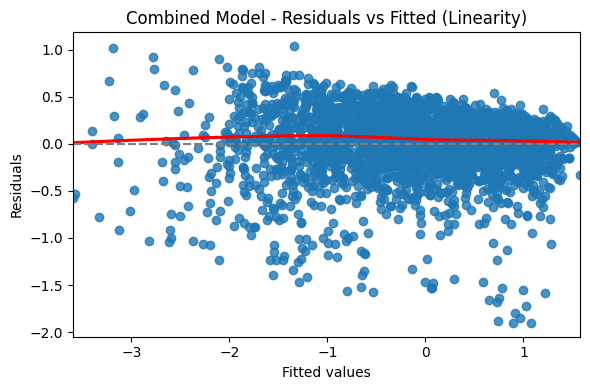


HOMOSCEDASTICITY (Breusch-Pagan):
  - LM stat = 167.065, p = 0.0000
  - F stat  = 3.345, p = 0.0000
  ⚠️ Heteroscedasticity detected (variance not constant)


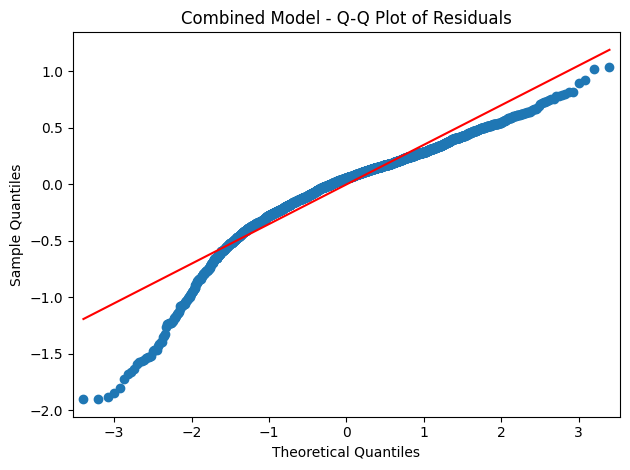


MULTICOLLINEARITY (Top 10 VIF):
                        Variable    VIF
0                          const  30.66
2     Emotional Likert.Lbal Sat    2.70
8   Emotional Likert.Lcont Imp     2.39
4     Emotional Likert.Lcnt Psy    2.39
5     Emotional Likert.Lcon Inc    2.32
13   Emotional Likert.Lres Ski     2.31
16  Functional Likert.Lcarprom D   2.25
14   Emotional Likert.Ltra Aut     2.25
3     Emotional Likert.Lcnt Com    2.17
9        Emotional Likert.Lgen     2.15


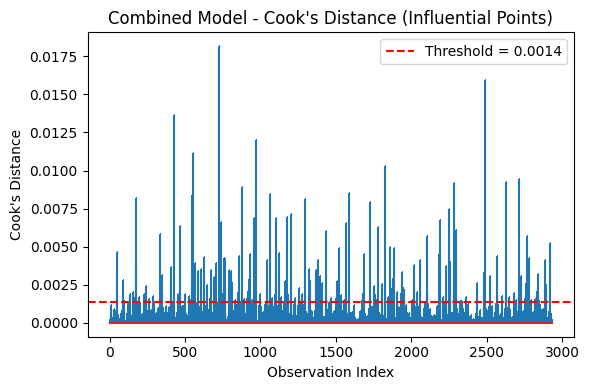


INFLUENTIAL POINTS (Cook's Distance):
  - 187 observations exceed threshold (4/n = 0.0014)


In [32]:
# Example: Run diagnostics for the 'combined' model
model_combined = results['combined']
X_train_combined = sm.add_constant(train_df[models_to_build['combined']])

run_regression_diagnostics(model_combined, X_train_combined, train_df['Preparedness levels'], model_name="Combined Model")

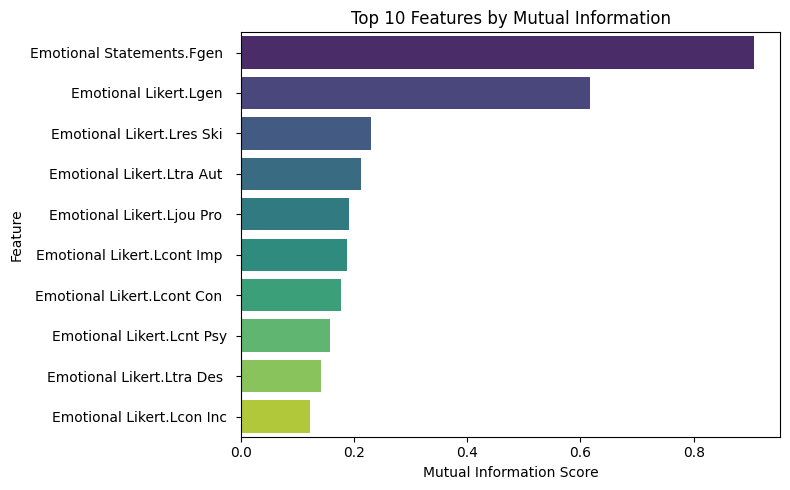

,Feature,Mutual_Info,F_stat,Pearson_corr,Spearman_corr
0,Emotional Statements.Fgen,0.907268,2103.771239,0.646284,0.636918
1,Emotional Likert.Lgen,0.616843,7410.533893,0.846429,0.848050
2,Emotional Likert.Lres Ski,0.230065,1372.266336,0.564572,0.600139
3,Emotional Likert.Ltra Aut,0.211775,1040.193097,0.511667,0.558577
4,Emotional Likert.Ljou Pro,0.191365,1053.455641,0.514061,0.525573
...,...,...,...,...,...
60,Functional Statements.Fmean Full,0.001280,76.381555,0.159315,0.124965
61,Emotional Statements.Fbal Anx,0.000000,4.961252,-0.041093,-0.035066
62,Gender_encoded,0.000000,0.020905,0.002670,0.008010
63,Age_encoded,0.000000,27.764420,0.096837,0.109602


In [33]:
all_features = list(chain.from_iterable(
        [y for x, y in feature_blocks.items() if x not in ['target', 'qualitative']]))

ranking_df = feature_informativeness(train_df[all_features], train_df['Preparedness levels'], top_n=10, plot=True)
ranking_df

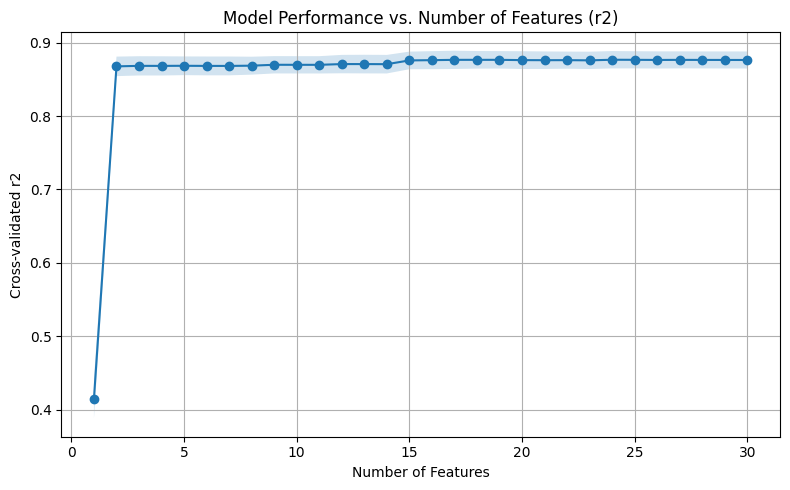


🏆 Best performance with 24 features: 0.877 ± 0.012
🧠 Top 24 most informative features used:
 1. Emotional Statements.Fgen  
 2. Emotional Likert.Lgen  
 3. Emotional Likert.Lres Ski  
 4. Emotional Likert.Ltra Aut  
 5. Emotional Likert.Ljou Pro  
 6. Emotional Likert.Lcont Imp  
 7. Emotional Likert.Lcont Con  
 8. Emotional Likert.Lcnt Psy 
 9. Emotional Likert.Ltra Des  
10. Emotional Likert.Lcon Inc 
11. Emotional Likert.Ljou Opt  
12. Functional Likert.Lcollea 
13. Disorganized, Careless.
14. Emotional Likert.Lres Fin  
15. Open To New Experiences, Complex.
16. Functional Likert.Lfin Lair 
17. Functional Likert.Luse Skills 
18. Emotional Likert.Lcnt Com 
19. Emotional Statements.Fjou Pro  
20. Dependable, Self-Disciplined.
21. Emotional Statements.Fcont Imp  
22. Functional Likert.Llearn Dev 
23. Functional Likert.Lpoorman 
24. Calm, Emotionally Stable.


,Num_Features,Mean_Score,Std_Score,Test_R2
0,1,0.415018,0.026949,0.465489
1,2,0.867772,0.013312,0.866232
2,3,0.868482,0.013117,0.867490
3,4,0.868424,0.013093,0.867547
4,5,0.868575,0.012750,0.868495
5,6,0.868400,0.012842,0.868485
6,7,0.868390,0.012830,0.868337
7,8,0.868716,0.012221,0.868337
8,9,0.869950,0.011808,0.870237
9,10,0.869892,0.011797,0.870281


In [34]:
results_df, best_features = incremental_feature_selection(train_df[all_features], train_df['Preparedness levels'], ranking_df, model=RidgeCV(), scoring='r2', max_features=30)
results_df


🔍 Training Ridge...


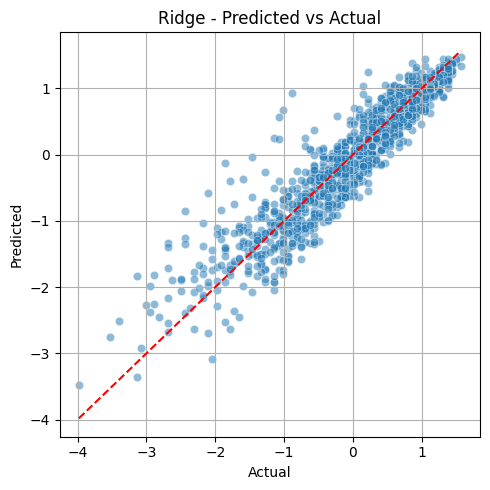

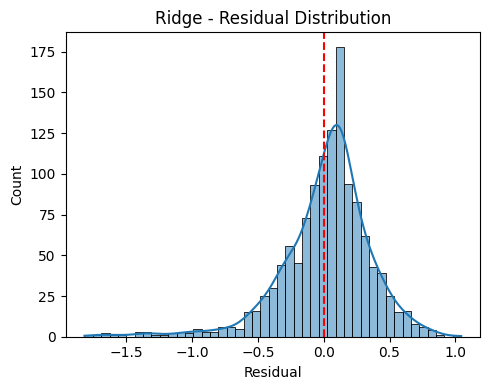


🔍 Training Lasso...


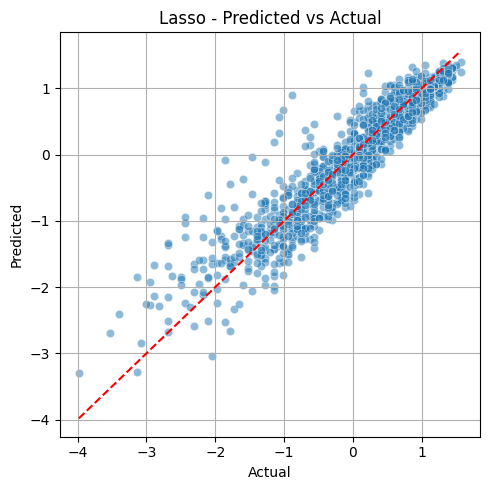

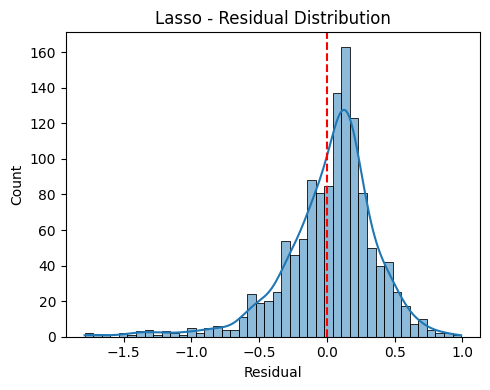


🔍 Training SVR...


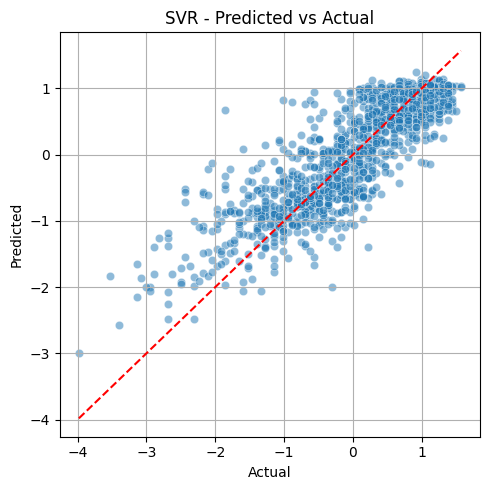

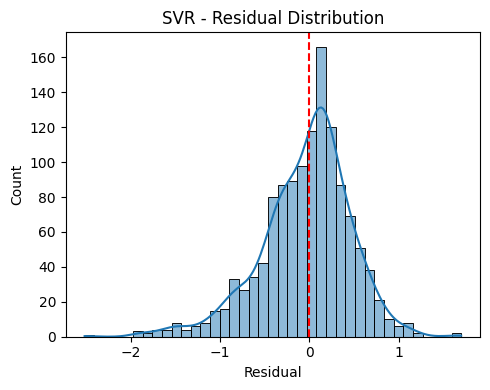


🔍 Training Random Forest...


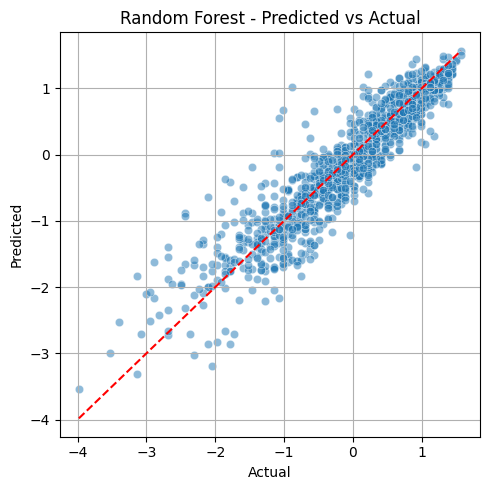

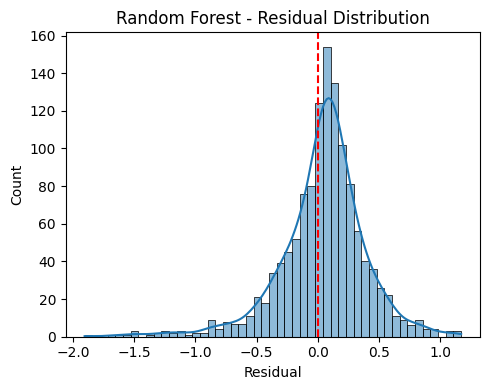


📊 Model Comparison:


,Model,cv_score,Test_R2,RMSE,MAE,Bias
0,Ridge,0.876805,0.879267,0.117730,0.247645,0.017941
1,Lasso,0.874020,0.874554,0.122326,0.254738,0.018128
3,Random Forest,0.859581,0.866945,0.129746,0.257777,0.038446
2,SVR,0.707444,0.735915,0.257517,0.382123,-0.041252


In [35]:
target_col = 'Preparedness levels'
results_df, models, preds, X_test = train_and_evaluate_models(train_df, test_df, target_col, best_features[:60])


🔎 SHAP Analysis for RidgeCV


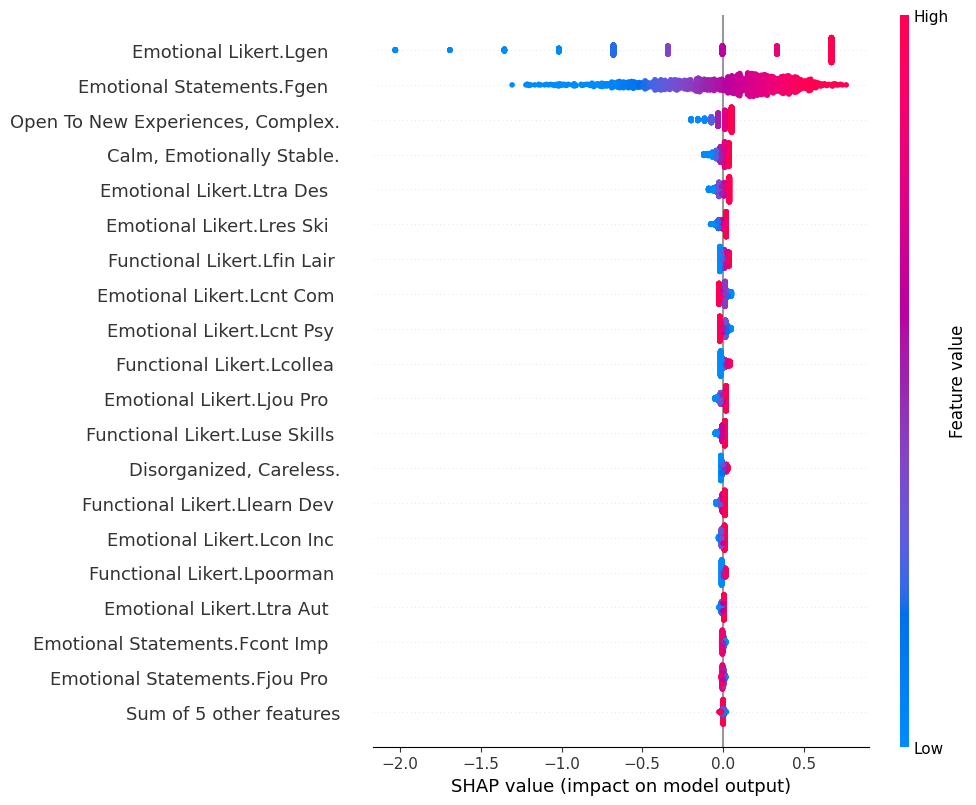

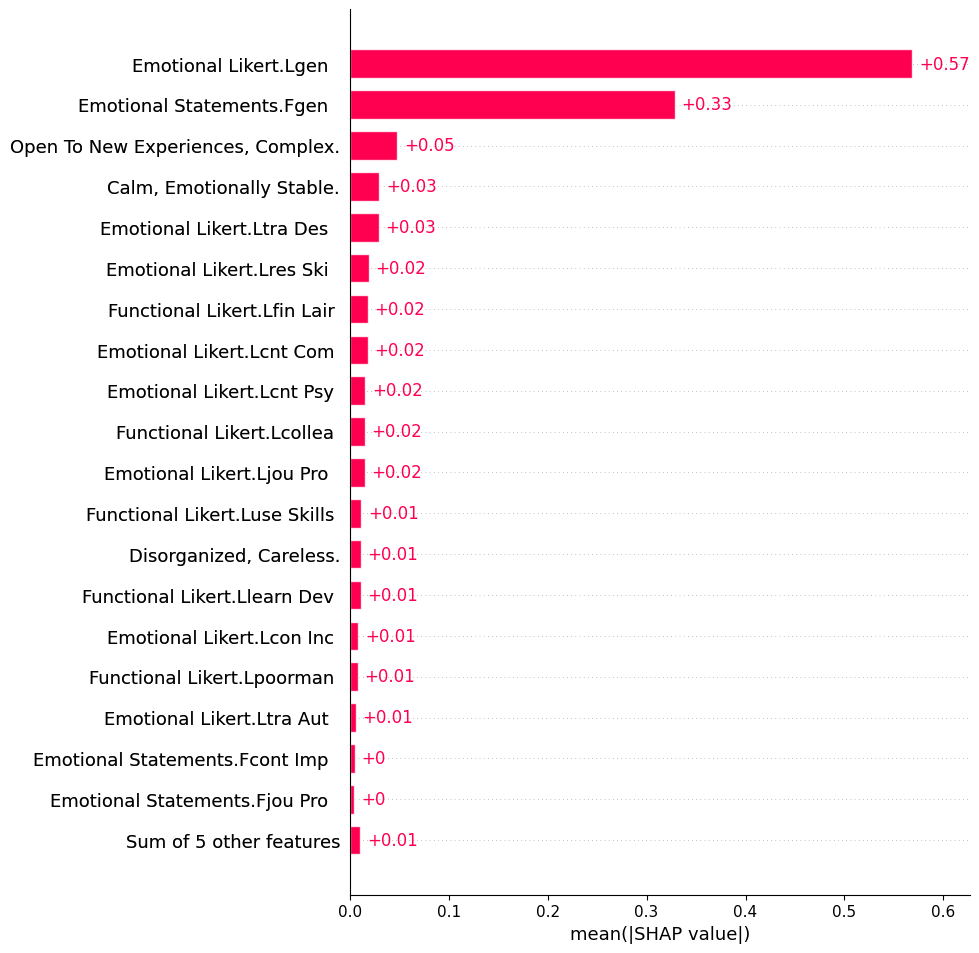

In [36]:
# SHAP for top model
top_model_name = results_df.iloc[0]['Model']
top_model = models[top_model_name]

shap_feature_importance(top_model, X_test, best_features[:15],
                        model_type='tree' if top_model_name == 'Random Forest' else 'linear')


🔎 SHAP Analysis for RandomForestRegressor


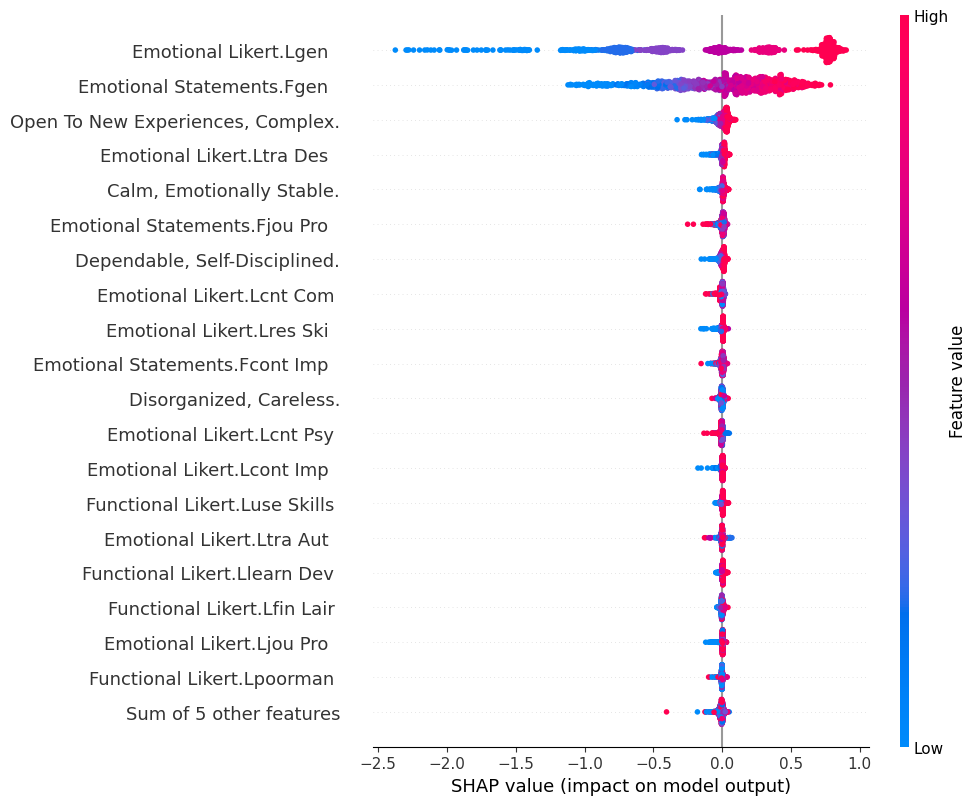

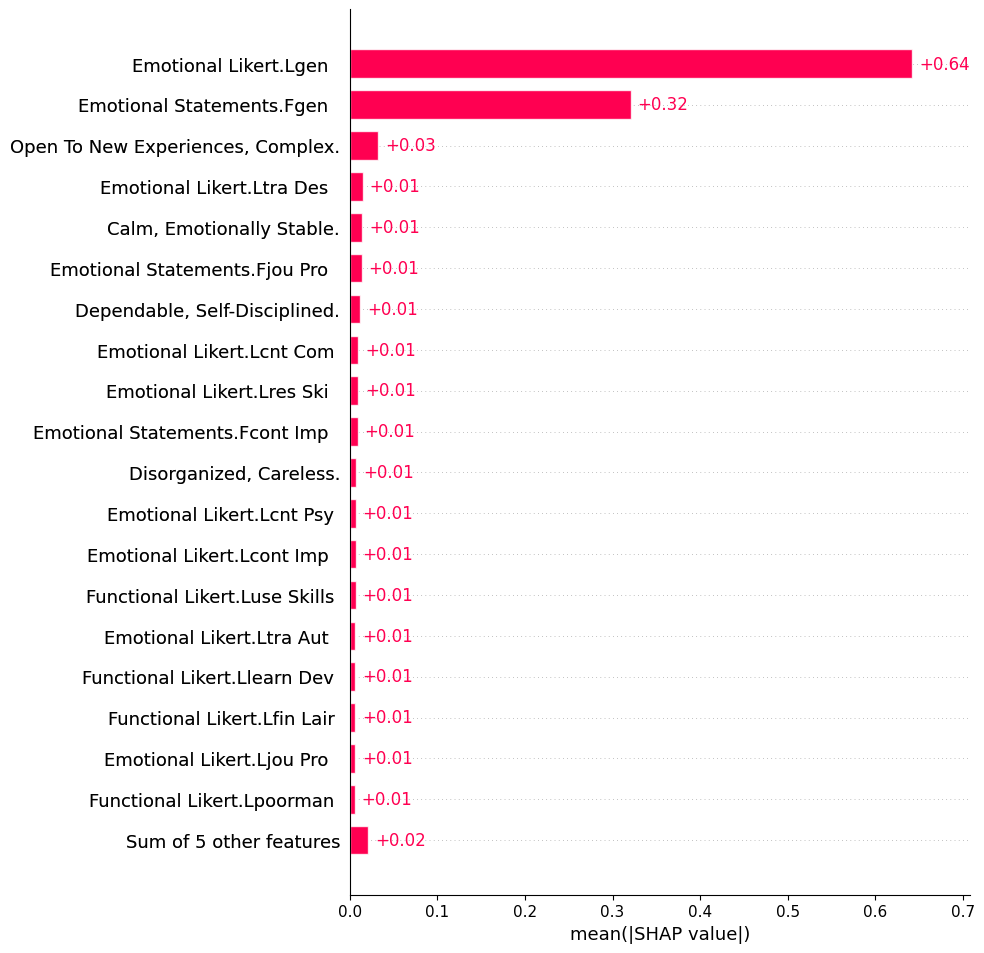

In [37]:
# SHAP for top model
top_model_name = results_df.iloc[2]['Model']
top_model = models[top_model_name]

shap_feature_importance(top_model, X_test, best_features[:15],
                        model_type='tree' if top_model_name == 'Random Forest' else 'linear')


In [38]:
results = enhanced_country_level_analysis(train_df, test_df, feature_blocks, all_features,
                                    target_col='Preparedness levels', country_col='Batch Group_encoded')


🌍 ENHANCED COUNTRY-LEVEL ANALYSIS
📍 Found 7 countries/regions: [4 2 0 1 5 3 6]

🔍 Feature Summary:
  - Selected features: 65
  - Explicit features: 26
  - Implicit features: 26

📊 PHASE 1: INDIVIDUAL COUNTRY MODELING
--------------------------------------------------

🏴 Country 4: 614 samples (Train: 442, Test: 172)
   ✅ Best Model: Lasso
   📊 Test R² = 0.872, CV = 0.879±0.017
   🎯 Top 3 Features: Emotional Statements.Fgen  , Extraverted, Enthusiastic., Emotional Likert.Lgen  

🏴 Country 2: 598 samples (Train: 421, Test: 177)
   ✅ Best Model: Lasso
   📊 Test R² = 0.887, CV = 0.883±0.026
   🎯 Top 3 Features: Emotional Statements.Fgen  , Open To New Experiences, Complex., Emotional Likert.Lgen  

🏴 Country 0: 613 samples (Train: 428, Test: 185)
   ✅ Best Model: Lasso
   📊 Test R² = 0.834, CV = 0.847±0.007
   🎯 Top 3 Features: Emotional Statements.Fgen  , Sympathetic, Warm., Extraverted, Enthusiastic.

🏴 Country 1: 592 samples (Train: 410, Test: 182)
   ✅ Best Model: Lasso
   📊 Test R² =

{'DE Fin': np.int64(0), 'FR Tech': np.int64(1), 'IT Fin': np.int64(2), 'SP Fin': np.int64(3), 'UK Energy': np.int64(4), 'US Pharma': np.int64(5), 'US Tech': np.int64(6)}


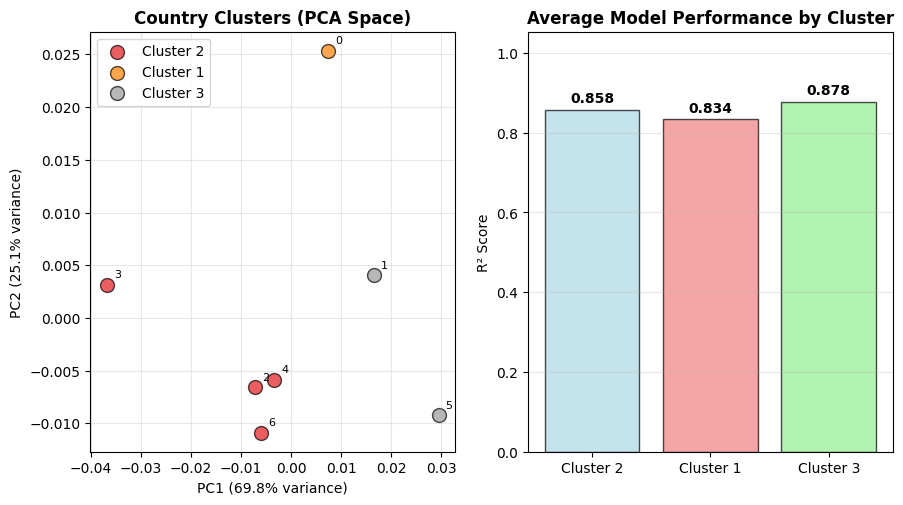

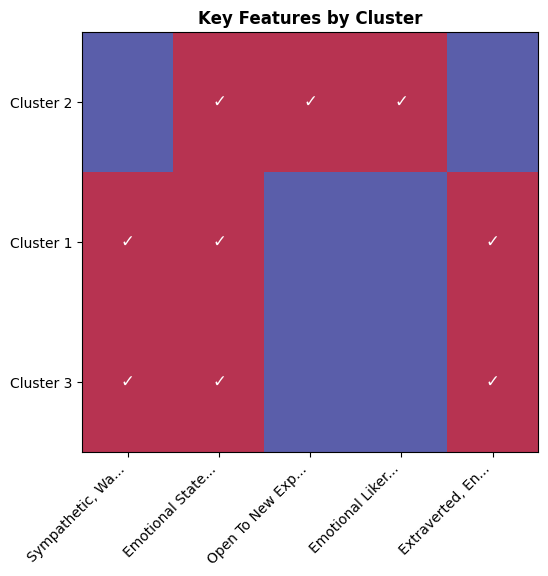

In [39]:
plot_country_clusters(results)
print(c_mapping)
c_heatmap(results, c_mapping)

In [40]:
# 1. Create preparedness level categories for both train and test
train_df = create_preparedness_bins(train_df)
test_df = create_preparedness_bins(test_df)


📊 PREPAREDNESS LEVEL DISTRIBUTION:
   ⚫ Very Low (<5.0): 211 (7.2%)
   🔴 Moderate (6.0-6.9): 510 (17.4%)
   🟠 Good (7.0-7.9): 624 (21.3%)
   🟡 High (8.0-8.9): 780 (26.6%)
   🟢 Excellent (9.0-10.0): 526 (17.9%)
   🟤 Low (5.0-5.9): 284 (9.7%)

📊 PREPAREDNESS LEVEL DISTRIBUTION:
   ⚫ Very Low (<5.0): 84 (6.7%)
   🔴 Moderate (6.0-6.9): 199 (15.8%)
   🟠 Good (7.0-7.9): 283 (22.5%)
   🟡 High (8.0-8.9): 308 (24.5%)
   🟢 Excellent (9.0-10.0): 262 (20.8%)
   🟤 Low (5.0-5.9): 123 (9.8%)


In [41]:
# 2. Run segmentation analysis on TRAINING data only (proper methodology)
print("\n📊 FITTING CLUSTERING MODELS ON TRAINING DATA...")
segmentation_results = advanced_segmentation_analysis(train_df, feature_blocks)


📊 FITTING CLUSTERING MODELS ON TRAINING DATA...

👥 ADVANCED SEGMENTATION ANALYSIS
🎯 Using 62 features for clustering

🔍 K-MEANS CLUSTERING ANALYSIS:
  K=2: Silhouette Score = 0.233, Inertia = 118657554
  K=3: Silhouette Score = 0.134, Inertia = 110311477
  K=4: Silhouette Score = 0.121, Inertia = 104588045
  K=5: Silhouette Score = 0.117, Inertia = 100308084
  K=6: Silhouette Score = 0.098, Inertia = 96823571
  K=7: Silhouette Score = 0.098, Inertia = 94380443
🏆 Optimal K selected: 2 (highest silhouette score)

🔍 GAUSSIAN MIXTURE MODEL ANALYSIS:
  K=2: BIC = 1073354, AIC = 1049230
  K=3: BIC = 1081465, AIC = 1045277
  K=4: BIC = 1078517, AIC = 1030264
  K=5: BIC = 1077277, AIC = 1016959
  K=6: BIC = 1106823, AIC = 1034441
  K=7: BIC = 1121592, AIC = 1037145
🏆 Optimal K for GMM: 2 (lowest BIC)

📊 K-MEANS SEGMENT PROFILES:

🏷️  Segment 0:
   Size: 1360 (46.3%)
   Preparedness: 6.543 ± 1.497
   Median: 6.600 | Min: 1.000 | Max: 9.900
   Top distinguishing features:
     Emotional Likert.

In [42]:
# 3. Apply fitted models to TEST data for validation
print("\n🔍 APPLYING FITTED MODELS TO TEST DATA...")
segmentation_results = apply_segmentation_to_test(segmentation_results, train_df, test_df, feature_blocks)


🔍 APPLYING FITTED MODELS TO TEST DATA...

🔬 APPLYING FITTED CLUSTERING MODELS TO TEST DATA

🔍 K-MEANS GENERALIZATION:
   Training Silhouette Score: 0.233
   Test Silhouette Score: 0.234
   Generalization Gap: -0.002
   ✅ Good generalization (gap < 0.05)

🔍 GMM GENERALIZATION:
   Training BIC: 1073354
   Test BIC: 478756
   BIC Difference: -594598

📊 CLUSTER STABILITY ANALYSIS:

K-MEANS CLUSTER STABILITY:
   Cluster 0:
     Train prep: 6.54 | Test prep: 6.54 | Diff: 0.01
     Train size: 1360 | Test size: 552 | Test ratio: 0.29
     Stability: ✅ Stable
   Cluster 1:
     Train prep: 8.23 | Test prep: 8.29 | Diff: 0.06
     Train size: 1575 | Test size: 707 | Test ratio: 0.31
     Stability: ✅ Stable

✅ GENERALIZATION SUMMARY:
   K-means generalization: Good
   Combined dataset ready for analysis with 4194 samples


In [43]:
# 4. Run enhanced segment characterization on FULL dataset (after fitting on train)
print("\n📋 CREATING SEGMENT PROFILES...")
full_df = pd.concat([train_df, test_df]).reset_index(drop=True)
full_df['cluster'] = segmentation_results['full_labels']
comparison_df = enhanced_segment_characterization(full_df, segmentation_results, feature_blocks)


📋 CREATING SEGMENT PROFILES...

🎯 ENHANCED SEGMENT CHARACTERIZATION & PROFILING

📊 DATASET OVERVIEW:
Total Samples: 4194
Preparedness Range: 1.0 - 10.0
Average Preparedness: 7.47 ± 1.55
⚠️ Could not load original data, using scaled values

🏷️  SEGMENT 1 PROFILE

🏆 SEGMENT NAME: DEVELOPING TALENT

📈 SIZE & PREPAREDNESS PROFILE:
   Size: 1,912 members (45.6% of total)
   Preparedness Level: 6.54 ± 1.48
   Range: 1.0 - 9.9
   Typical Range (25%-75%): 5.7 - 7.6
   Category: 🟠 MODERATE PREPAREDNESS

👥 DEMOGRAPHIC PROFILE:
   Gender Distribution: {'Female': 967, 'Male': 924, 'Non-Binary': 18, 'Prefer Not to Answer': 2, 'Other': 1}
   Age Distribution: {'18-24': 677, '25-40': 644, '41-64': 591}
   Top 3 Batch Groups: {'UK Energy': 338, 'DE Fin': 319, 'FR Tech': 282}

⭐ TOP DISTINGUISHING FEATURES WITH ORIGINAL SCORES:
   DEVELOPING TALENT are characterized by:

   1. Emotional Likert.Lcont Imp                   
      Direction: ↘️ LOWER than average
      Segment Average: 16.7 (vs Populatio


🎨 CREATING SEGMENT VISUALIZATION WITH FEATURES...
⚠️ Using scaled data for visualization


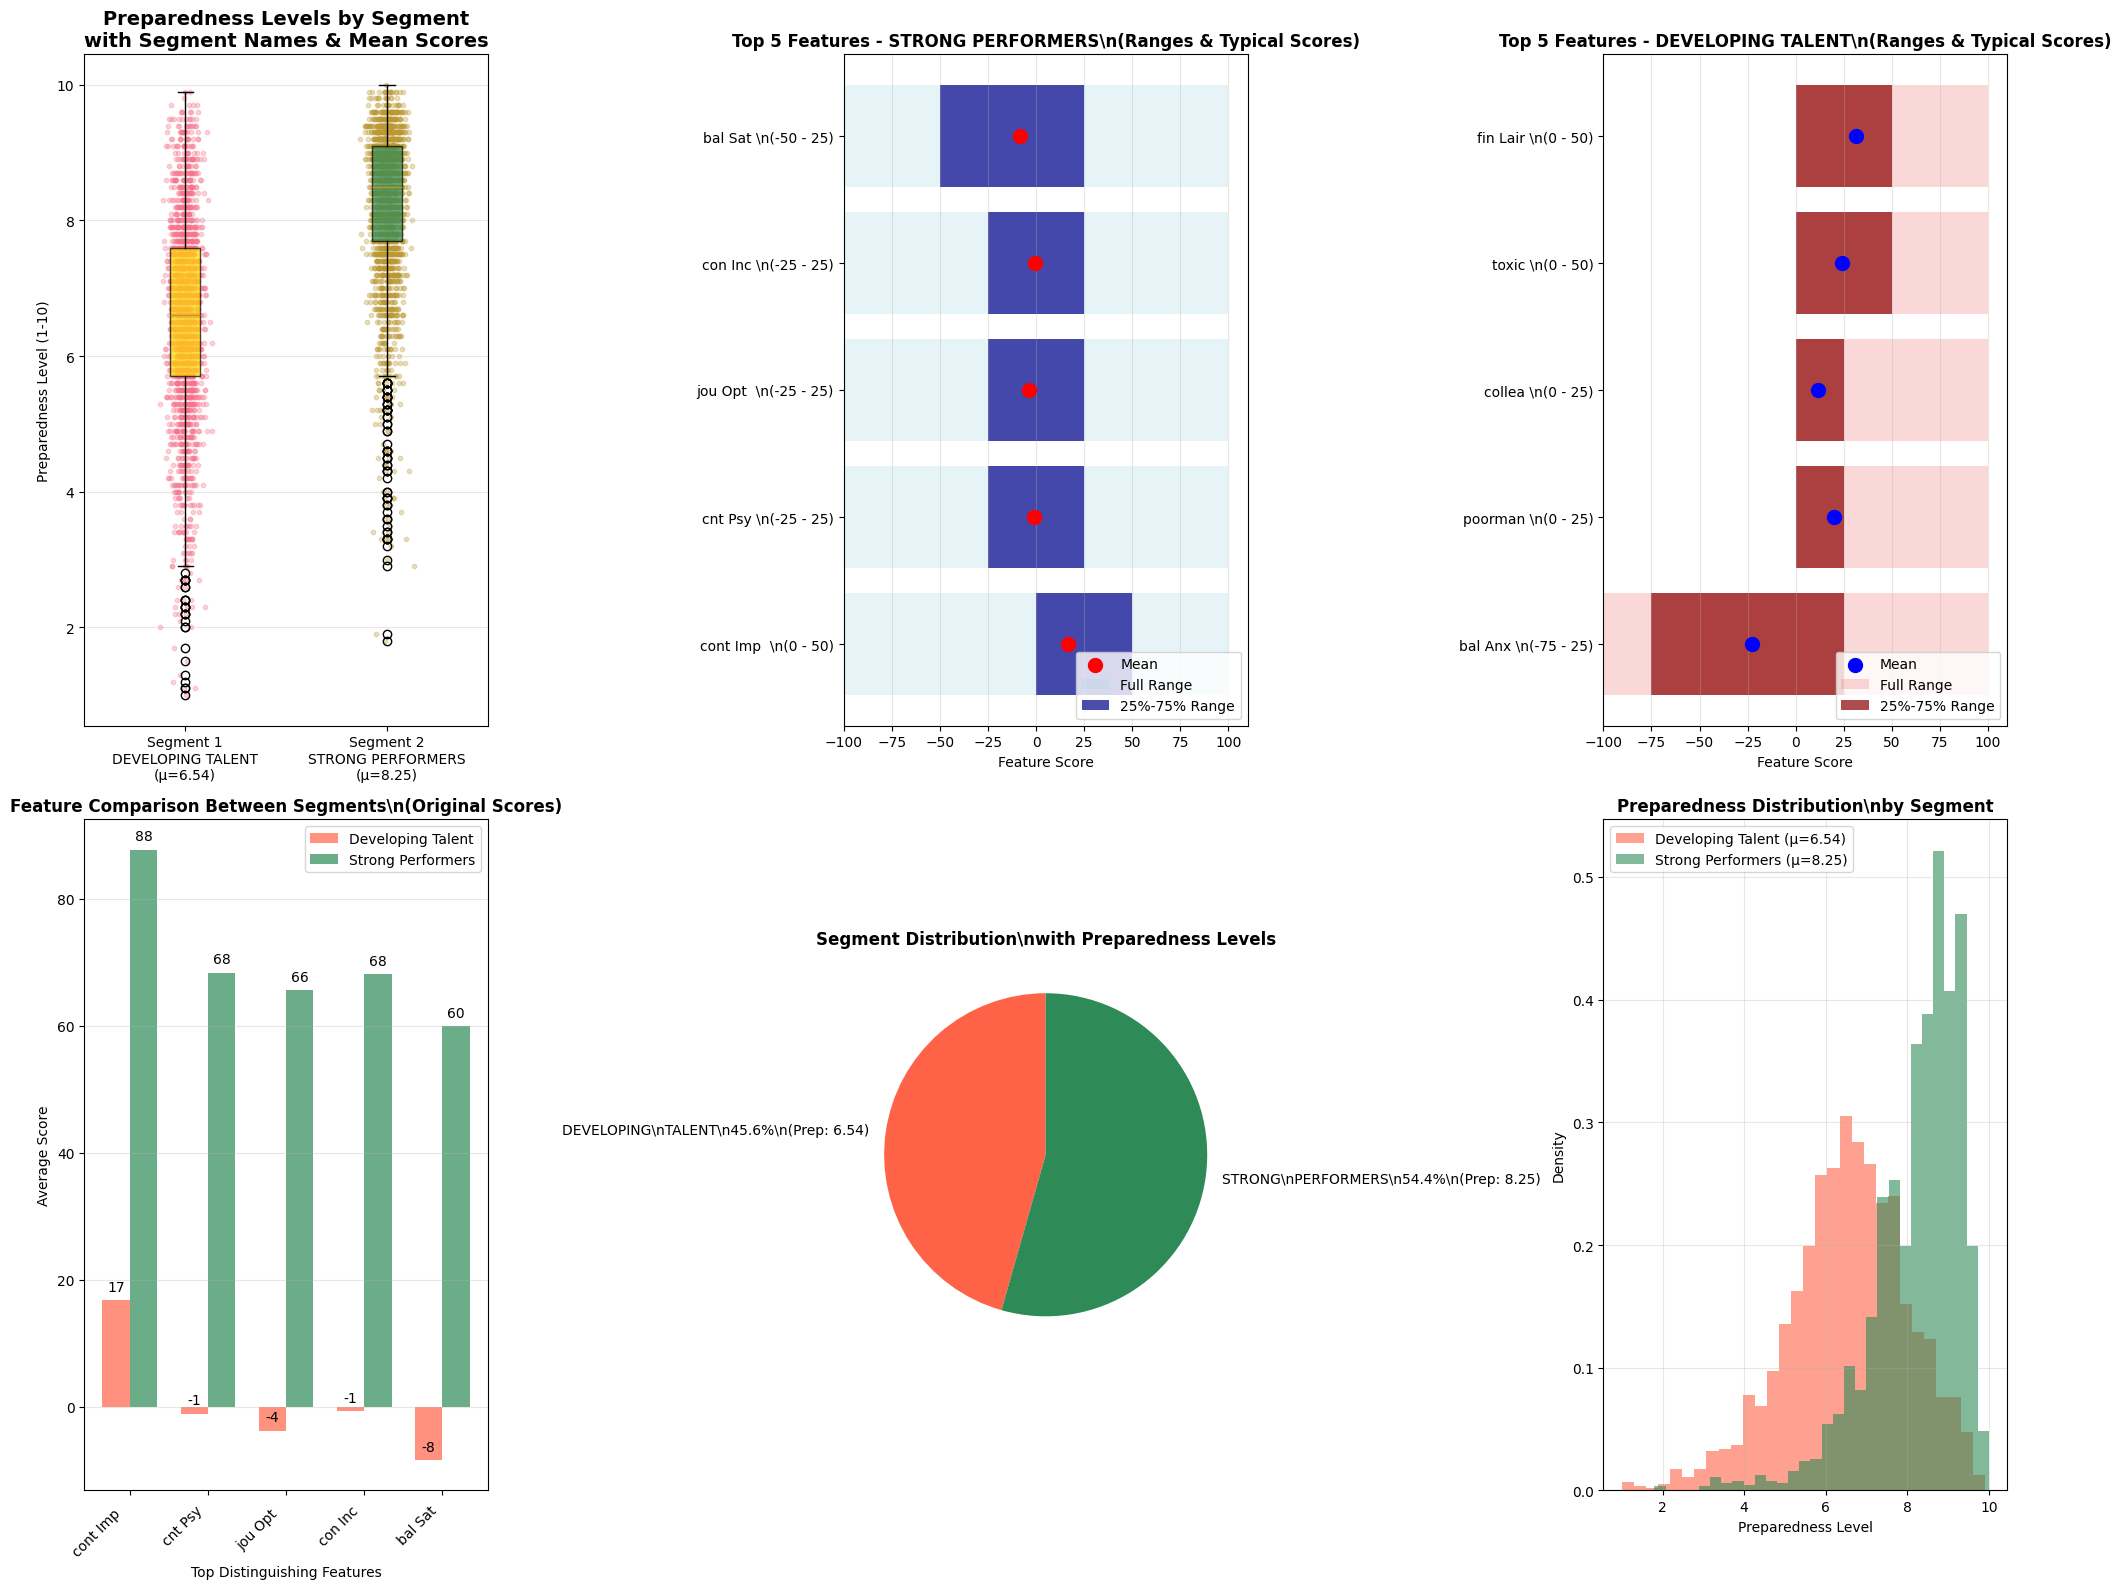

\n====================================================================================================
📊 SEGMENT ANALYSIS SUMMARY WITH FEATURE RANGES
\n🏷️ SEGMENT 1: DEVELOPING TALENT
   📊 Size: 1,912 members (45.6%)
   📈 Preparedness: 6.54 ± 1.48
   📍 Range: 1.0 - 9.9
   🔝 TOP DISTINGUISHING FEATURES (Higher than Population):
      1. bal Anx 
         Score: 16.7 (higher than average)
         Typical Range: 0.0 - 50.0
      2. poorman 
         Score: 54.6 (higher than average)
         Typical Range: 25.0 - 75.0
      3. collea 
         Score: 45.6 (higher than average)
         Typical Range: 25.0 - 75.0
\n🏷️ SEGMENT 2: STRONG PERFORMERS
   📊 Size: 2,282 members (54.4%)
   📈 Preparedness: 8.25 ± 1.12
   📍 Range: 1.8 - 10.0
   ⚠️ TOP DISTINGUISHING FEATURES (Lower than Population):
      1. bal Anx 
         Score: -22.8 (lower than average)
         Typical Range: -75.0 - 25.0
      2. poorman 
         Score: 20.1 (lower than average)
         Typical Range: 0.0 - 25.0
      3. 

In [47]:
# 5. Create comprehensive plots with preparedness scores and feature ranges
print("\n🎨 CREATING SEGMENT VISUALIZATION WITH FEATURES...")
viz_fig = plot_segment_analysis_with_features(full_df, segmentation_results, feature_blocks)